In [ ]:
"""
Sistema de Predição de Crimes - TCC

Autor: Raphael Lugon Campo Dall'Orto
Orientador: Giovanni Comarela
Instituição: Universidade Federal do Espírito Santo (UFES)
Ano: 2025

===========================================

Sistema de Machine Learning para previsão de volume e tipo de crimes, 
utilizando Random Forest e XGBoost com validação temporal K-Fold e 
otimização automática de hiperparâmetros.

Funcionalidades:
- Predição de volume de crimes por local e período
- Classificação de tipos de crime mais prováveis
- Validação temporal K-Fold (sem data leakage)
- Otimização de hiperparâmetros
- Monitoramento de drift em produção
- Sistema de logging configurável

Componentes principais:
- CONFIG: Dicionário global com todas as configurações
- FeatureEngineering: Criação de features temporais e espaciais
- DriftMonitor: Monitoramento de degradação de performance
- HyperparameterOptimizer: Otimização de hiperparâmetros via grid search
- VolumePredictor: Predição de volume de crimes
- CrimeClassifier: Classificação de tipos de crime
- CrimePredictionSystem: Interface unificada do sistema
"""

import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional
import logging
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score,
                            mean_absolute_error, mean_squared_error, r2_score)
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


# =============================================================================
# CONFIGURAÇÕES GLOBAIS
# =============================================================================


CONFIG = {
    # Monitoramento de drift
    'drift_threshold_degradacao': 0.10,  # 10% de degradação = alerta
    'drift_threshold_reotimizar': 0.20,  # 20% de degradação = reotimizar
    
    # Parâmetros de treino
    'n_folds_default': 3,               # Número de folds para validação
    'meses_janela_default': 12,         # Janela temporal padrão
    'random_state': 42,                 # Seed para reprodutibilidade
    'n_jobs': -1,                       # Usar todos os cores (-1)
    
    # Features de lag temporal
    'lags_dias': [1, 7, 30],            # Lags de 1, 7 e 30 dias
    'media_movel_dias': 7,              # Média móvel de 7 dias
    
    # Binning espacial
    'bins_lat_lon': 10,                 # Discretização de coordenadas
    
    # Hiperparâmetros padrão (usados quando não otimiza)
    'params_default': {
        'rf_regressor': {
            'n_estimators': 100,
            'max_depth': 15,
            'min_samples_split': 5,
            'min_samples_leaf': 1
        },
        'rf_classifier': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'class_weight': 'balanced'
        },
        'xgboost': {
            'n_estimators': 200,
            'max_depth': 6,
            'learning_rate': 0.1
        }
    },
    
    # Grids para otimização de hiperparâmetros
    'param_grids': {
        'rf_regressor': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'rf_classifier': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        'xgboost': {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    }
}


# =============================================================================
# CONFIGURAÇÃO DE LOGGING
# =============================================================================

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)-8s | %(message)s',
    datefmt='%H:%M:%S'
)

def log_section(title: str, width: int = 70):
    """Imprime seção destacada nos logs."""
    logging.info("=" * width)
    logging.info(title.center(width))
    logging.info("=" * width)

# ==========================================
# FUNÇÕES UTILITÁRIAS
# ==========================================

def validar_n_folds(n_folds: int, total_meses: int) -> None:
    """
    Valida se o número de folds é adequado para divisão em meses completos.
    """
    folds_validos = {
        12: [2, 3, 5],
        11: [2],
        10: [2, 4],
        9: [2],
        8: [2, 3],
        6: [2],
    }
    
    validos = folds_validos.get(total_meses, [])
    
    if not validos:
        for possivel in [2, 3, 4, 5, 6]:
            if total_meses % (possivel + 1) == 0:
                validos.append(possivel)
    
    if n_folds not in validos:
        val_window = total_meses // (n_folds + 1)
        meses_usados = val_window * (n_folds + 1)
        meses_sobra = total_meses - meses_usados
        
        msg = (
            f"\n{'='*70}\n"
            f"ERRO: Número de folds inadequado!\n"
            f"{'='*70}\n"
            f"Você tentou usar: {n_folds} folds\n"
            f"Total de meses disponíveis: {total_meses}\n"
            f"\n"
            f"Com {n_folds} folds:\n"
            f"  • Cada janela de validação teria: {val_window} meses\n"
            f"  • Meses utilizados: {meses_usados}\n"
            f"  • Meses desperdiçados: {meses_sobra} ❌\n"
            f"\n"
            f"Para {total_meses} meses, use APENAS: {validos}\n"
            f"\n"
            f"Detalhamento das opções válidas:\n"
        )
        
        for fold_opt in validos:
            window = total_meses // (fold_opt + 1)
            msg += f"  • {fold_opt} folds: janelas de {window} meses cada\n"
        
        msg += f"{'='*70}\n"
        
        raise ValueError(msg)
    
    logging.info(f"✓ Validação OK: {n_folds} folds para {total_meses} meses")


# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

class FeatureEngineering:
    """
    Criação centralizada de features para modelos de predição de crimes.
    
    Cria features temporais (dia, mês, trimestre, dia da semana), 
    espaciais (binning de lat/lon) e features de lag temporal para 
    capturar padrões históricos.
    
    Attributes:
        Nenhum atributo de instância necessário.
    """
    
    def criar_features_completas(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Cria todas as features temporais e espaciais de uma vez.
        
        Features criadas:
        - Temporais: Ano, Mês, Dia, DiaAno, Semana, DiaDaSemana, etc.
        - Período do dia: madrugada, manhã, tarde, noite
        - Espaciais: binning de latitude/longitude em regiões
        - Indicadores: FimDeSemana, trimestre, quinzena
        
        Args:
            df: DataFrame com coluna 'DataFato' (e opcionalmente 'hora_dt', 
                'Latitude', 'Longitude')
        
        Returns:
            DataFrame com novas colunas de features adicionadas
        """
        # Temporais
        df['Ano'] = df['DataFato'].dt.year
        df['Mes'] = df['DataFato'].dt.month
        df['Dia'] = df['DataFato'].dt.day
        df['DiaAno'] = df['DataFato'].dt.dayofyear
        df['Semana'] = df['DataFato'].dt.isocalendar().week
        df['NumDiaSemana'] = df['DataFato'].dt.weekday
        df['trimestre'] = df['DataFato'].dt.quarter
        df['quinzena'] = (df['DataFato'].dt.day > 15).astype(int)
        # Flag de fim de semana (sábado=5, domingo=6)
        df['FimDeSemana'] = df['NumDiaSemana'].isin([5, 6]).astype(int)
        # Mapeamento textual do dia da semana
        dias = {0:"segunda",1:"terça",2:"quarta",3:"quinta",4:"sexta",5:"sábado",6:"domingo"}
        df['DiaDaSemana'] = df['NumDiaSemana'].map(dias)
        
        # Período do dia
        if 'hora_dt' in df.columns:
            df['periodo_dia'] = df['hora_dt'].apply(self._periodo_dia)
            df['hora_num'] = df['hora_dt'].dt.hour + df['hora_dt'].dt.minute/60
        
        # Espaciais
        if 'Latitude' in df.columns and 'Longitude' in df.columns:
            df['regiao_lat'] = pd.cut(df['Latitude'], bins=CONFIG['bins_lat_lon'], labels=False)
            df['regiao_lon'] = pd.cut(df['Longitude'], bins=CONFIG['bins_lat_lon'], labels=False)
        
        return df
    
    def criar_features_lag(self, df: pd.DataFrame, groupby_cols: List[str], 
                          target_col: str = 'volume_crimes') -> pd.DataFrame:
        """
        Cria features de lag temporal (atraso no tempo) para capturar padrões históricos.
        
        Features lag permitem ao modelo "ver o passado" e identificar tendências para ajudar a 
        prever o futuro.
        Criar lags é uma maneira de incorporar memória temporal ao modelo.
        Por exemplo, se houve muitos crimes ontem, é mais provável que haja 
        crimes hoje.
        
        Features criadas:
        - Lags: valores de N dias atrás (ex: 1, 7, 30 dias)
        - Média móvel: média dos últimos N dias
        
        Args:
            df: DataFrame agregado por período temporal
            groupby_cols: Colunas para agrupar (ex: ['Bairro', 'Municipio'])
            target_col: Coluna alvo para calcular lags (padrão: 'volume_crimes')
        
        Returns:
            DataFrame com colunas de lag adicionadas
        """
        for dias in CONFIG['lags_dias']:
            df[f'{target_col}_{dias}d_atras'] = df.groupby(groupby_cols)[target_col].shift(dias).fillna(0)
        
        df[f'{target_col}_media_movel_{CONFIG["media_movel_dias"]}d'] = df.groupby(groupby_cols)[target_col].transform(
            lambda x: x.rolling(CONFIG['media_movel_dias'], min_periods=1).mean()
        )
        return df
    
    @staticmethod
    def _periodo_dia(hora_dt) -> str:
        """
        Classifica hora em período do dia.
        
        Períodos:
        - madrugada: 00:00 - 05:59
        - manha: 06:00 - 11:59
        - tarde: 12:00 - 17:59
        - noite: 18:00 - 23:59
        
        Args:
            hora_dt: Timestamp com hora
        
        Returns:
            String com período ('madrugada', 'manha', 'tarde', 'noite', 'indeterminada')
        """
        if pd.isna(hora_dt): return "indeterminada"
        h = hora_dt.hour
        if h < 6: return "madrugada"
        elif h < 12: return "manha"
        elif h < 18: return "tarde"
        else: return "noite"

# =============================================================================
# VISUALIZER
# =============================================================================

class Visualizer:
    """Classe para centralizar visualizações"""
    
    @staticmethod
    def plot_distribuicao(series, title, ax, kind='bar', **kwargs):
        """Plota distribuição de uma série"""
        series.plot(kind=kind, ax=ax, **kwargs)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
    
    @staticmethod
    def plot_heatmap(pivot_data, title, ax):
        """Plota heatmap"""
        sns.heatmap(pivot_data, cmap='YlOrRd', ax=ax)
        ax.set_title(title)
    
    @staticmethod
    def criar_subplot_grid(nrows, ncols, figsize=(15, 10)):
        """Cria grid de subplots"""
        return plt.subplots(nrows, ncols, figsize=figsize)


# =============================================================================
# ANÁLISE EXPLORATÓRIA
# =============================================================================

class ExploratoryAnalyzer:
    """Classe para análises exploratórias"""
    
    def __init__(self, df):
        self.df = df
        self.viz = Visualizer()
    
    def analise_temporal_basica(self):
        """Análise temporal básica"""
        print("\n=== ANÁLISE TEMPORAL BÁSICA ===")
        
        fig, axes = self.viz.criar_subplot_grid(2, 3)
        
        # Crimes por mês
        self.viz.plot_distribuicao(
            self.df.groupby('Mes').size(),
            'Crimes por Mês', axes[0,0]
        )
        
        # Crimes por dia da semana
        ordem_dias = ['segunda', 'terça', 'quarta', 'quinta', 'sexta', 'sábado', 'domingo']
        crimes_dia = self.df.groupby('DiaDaSemana').size().reindex(ordem_dias)
        self.viz.plot_distribuicao(crimes_dia, 'Crimes por Dia da Semana', axes[0,1])
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Crimes por período
        self.viz.plot_distribuicao(
            self.df.groupby('periodo_dia').size(),
            'Crimes por Período do Dia', axes[0,2]
        )
        axes[0,2].tick_params(axis='x', rotation=45)
        
        # Top tipos de crime
        self.viz.plot_distribuicao(
            self.df['NOME_COMPLETO_INCIDENTE'].value_counts().head(10),
            'Top 10 Tipos de Crime', axes[1,0], kind='barh'
        )
        
        # Top objetos
        self.viz.plot_distribuicao(
            self.df['NOME_TIPO_OBJETO'].value_counts().head(10),
            'Top 10 Objetos', axes[1,1], kind='barh'
        )
        
        # Heatmap hora vs dia
        if not self.df['hora_dt'].isna().all():
            pivot = self.df.groupby([self.df['hora_dt'].dt.hour, 'DiaDaSemana']).size().unstack(fill_value=0)
            self.viz.plot_heatmap(pivot, 'Heatmap Hora vs Dia', axes[1,2])
        
        plt.tight_layout()
        plt.show()
        
        self._print_insights_celulares()
    
    def analise_temporal_avancada(self):
        """Análise temporal detalhada"""
        print("\n=== ANÁLISE TEMPORAL AVANÇADA ===")
        
        fig, axes = self.viz.criar_subplot_grid(2, 2)
        
        # Tendência mensal
        crimes_mensal = self.df.groupby(self.df['DataFato'].dt.to_period('M')).size()
        axes[0,0].plot(crimes_mensal.index.astype(str), crimes_mensal.values, marker='o')
        axes[0,0].set_title('Tendência Mensal')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)
        
        # Sazonalidade trimestral
        self.viz.plot_distribuicao(
            self.df.groupby('trimestre').size(),
            'Crimes por Trimestre', axes[0,1]
        )
        
        # Fim de semana vs dia útil
        fds_data = self.df.groupby(['FimDeSemana', 'NOME_COMPLETO_INCIDENTE']).size().unstack(fill_value=0).head(5)
        fds_data.T.plot(kind='barh', ax=axes[1,0])
        axes[1,0].set_title('Fim de Semana vs Dia Útil (Top 5 Crimes)')
        axes[1,0].legend(['Dia Útil', 'Fim de Semana'])
        
        # Distribuição por hora
        if self.df['hora_num'].notna().any():
            self.df['hora_num'].hist(bins=24, ax=axes[1,1], edgecolor='black')
            axes[1,1].set_title('Distribuição por Hora do Dia')
            axes[1,1].set_xlabel('Hora')
        
        plt.tight_layout()
        plt.show()
    
    def analise_espacial(self):
        """Análise de padrões espaciais"""
        print("\n=== ANÁLISE ESPACIAL ===")
        
        fig, axes = self.viz.criar_subplot_grid(2, 2)
        
        # Top municípios
        top_municipios = self.df['NomeMunicipio'].value_counts().head(10)
        self.viz.plot_distribuicao(top_municipios, 'Top 10 Municípios', axes[0,0], kind='barh')
        
        # Top bairros
        self.viz.plot_distribuicao(
            self.df['EnderecoBairro'].value_counts().head(15),
            'Top 15 Bairros', axes[0,1], kind='barh'
        )
        
        # Tipos de local
        self.viz.plot_distribuicao(
            self.df['NOME_TIPO_LOCAL'].value_counts().head(10),
            'Tipos de Local Mais Afetados', axes[1,0]
        )
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Mapa de calor geográfico
        coords = self.df[(self.df['Latitude'] != 0) & (self.df['Longitude'] != 0)]
        if len(coords) > 0:
            axes[1,1].hexbin(coords['Longitude'], coords['Latitude'], gridsize=30, cmap='YlOrRd')
            axes[1,1].set_title('Densidade Geográfica')
            axes[1,1].set_xlabel('Longitude')
            axes[1,1].set_ylabel('Latitude')
        
        plt.tight_layout()
        plt.show()
        
        self._print_hotspots(top_municipios)
    
    def analise_tipos_crime(self):
        """Análise por tipo de crime e objeto"""
        print("\n=== ANÁLISE POR TIPO DE CRIME ===")
        
        fig, axes = self.viz.criar_subplot_grid(2, 2)
        
        # Furto vs Roubo
        crime_action = self.df['NOME_TIPO_ACAO_OBJETO'].value_counts()
        crime_action.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%')
        axes[0,0].set_title('Furto vs Roubo')
        
        # Objetos furtados
        furto_obj = self.df[self.df['NOME_TIPO_ACAO_OBJETO'] == 'FURTADO']['NOME_TIPO_OBJETO'].value_counts().head(5)
        self.viz.plot_distribuicao(furto_obj, 'Top 5 Objetos Furtados', axes[0,1], kind='barh', color='orange')
        
        # Objetos roubados
        roubo_obj = self.df[self.df['NOME_TIPO_ACAO_OBJETO'] == 'ROUBADO']['NOME_TIPO_OBJETO'].value_counts().head(5)
        self.viz.plot_distribuicao(roubo_obj, 'Top 5 Objetos Roubados', axes[1,0], kind='barh', color='red')
        
        # Marcas de celulares
        telefones = self.df[self.df['NOME_TIPO_OBJETO'] == 'APARELHOS TELEFONICOS']
        if len(telefones) > 0:
            self.viz.plot_distribuicao(
                telefones['Marca'].value_counts().head(10),
                'Top Marcas de Celulares', axes[1,1]
            )
            axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def analise_correlacoes(self):
        """Análise de correlações"""
        print("\n=== ANÁLISE DE CORRELAÇÕES ===")
        
        # Matriz de correlação
        numeric_cols = ['Mes', 'Dia', 'hora_num', 'FimDeSemana', 'NumDiaSemana']
        if all(col in self.df.columns for col in numeric_cols):
            corr_matrix = self.df[numeric_cols].corr()
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title('Correlações entre Variáveis Temporais')
            plt.show()
        
        # Heatmap hora x dia da semana
        df_com_hora = self.df[self.df['hora_num'].notna()].copy()
        if len(df_com_hora) > 0:
            pivot_hora_dia = df_com_hora.pivot_table(
                values='Id', 
                index=df_com_hora['hora_num'].astype(int), 
                columns='DiaDaSemana', 
                aggfunc='count',
                fill_value=0
            )
            
            plt.figure(figsize=(12, 6))
            self.viz.plot_heatmap(pivot_hora_dia, 'Padrão: Hora x Dia da Semana', plt.gca())
            plt.xlabel('Dia da Semana')
            plt.ylabel('Hora do Dia')
            plt.show()
    
    def _print_insights_celulares(self):
        """Insights sobre furto de celulares"""
        print("\n=== INSIGHTS PRINCIPAIS ===")
        celular_furtos = self.df[self.df['NOME_TIPO_OBJETO'] == 'APARELHOS TELEFONICOS']
        
        if len(celular_furtos) > 0:
            analise = celular_furtos.groupby(['NOME_TIPO_LOCAL', 'periodo_dia', 'DiaDaSemana']).size()
            analise = analise.reset_index(name='count').sort_values('count', ascending=False).head(10)
            
            print("Top 10 padrões para furto de aparelhos telefônicos:")
            for _, row in analise.iterrows():
                prob = (row['count'] / len(celular_furtos)) * 100
                print(f"  {row['NOME_TIPO_LOCAL']} | {row['periodo_dia']} | {row['DiaDaSemana']}: "
                      f"{prob:.1f}% ({row['count']} casos)")
    
    def _print_hotspots(self, top_municipios):
        """Imprime hotspots por município"""
        print("\nHotspots por município:")
        for municipio in top_municipios.head(5).index:
            total = top_municipios[municipio]
            crime_comum = self.df[self.df['NomeMunicipio'] == municipio]['NOME_COMPLETO_INCIDENTE'].mode()
            crime_comum = crime_comum[0] if len(crime_comum) > 0 else 'N/A'
            print(f"  {municipio}: {total} crimes - Mais comum: {crime_comum}")
    
    def analise_completa(self):
        """Executa todas as análises"""
        self.analise_temporal_basica()
        self.analise_temporal_avancada()
        self.analise_espacial()
        self.analise_tipos_crime()
        self.analise_correlacoes()

# =============================================================================
# DRIFT MONITOR
# =============================================================================

class DriftMonitor:
    """
    Monitor de performance e detecção de drift (degradação do modelo).
    
    Drift ocorre quando o modelo perde performance ao longo do tempo devido a
    mudanças nos padrões dos dados quando padrões sociais, econômicos e sazonais mudam. 
    Este monitor:
    - Registra performance em cada período
    - Compara com baseline inicial
    - Detecta degradação significativa
    - Recomenda retreino ou reotimização
    
    Thresholds configuráveis em CONFIG:
    - drift_threshold_degradacao: 10% = retreinar
    - drift_threshold_reotimizar: 20% = reotimizar hiperparâmetros
    
    Attributes:
        historico: Lista de registros de performance por período
        baseline: Performance inicial (referência para comparação)
    """
    
    def __init__(self):
        self.historico = []
        self.baseline = None
    
    def registrar(self, periodo: str, metrica: float, detalhes: Dict = None):
        """
        Registra performance de um período.
        
        Args:
            periodo: Identificador do período (ex: '2025-01')
            metrica: Valor da métrica principal (MAE para volume, F1 para classificação)
            detalhes: Dict opcional com métricas adicionais
        """
        registro = {
            'periodo': periodo,
            'timestamp': datetime.now(),
            'metrica': metrica,
            'detalhes': detalhes or {}
        }
        self.historico.append(registro)
        
        if self.baseline is None:
            self.baseline = metrica
            logging.info(f"Baseline definido: {metrica:.3f}")
    
    def verificar_drift(self) -> Tuple[bool, bool, str]:
        """
        Verifica se houve drift na performance do modelo.
        
        Compara performance atual com:
        1. Baseline inicial (primeira medição)
        2. Média dos últimos 3 períodos
        
        Returns:
            Tupla (retreinar, reotimizar, mensagem):
            - retreinar: True se degradação > 10% vs média recente
            - reotimizar: True se degradação > 20% vs baseline
            - mensagem: Descrição do status
        """
        if len(self.historico) < 2:
            return False, False, "Histórico insuficiente"
        
        atual = self.historico[-1]['metrica']
        deg_baseline = (self.baseline - atual) / self.baseline
        
        ultimos_3 = [h['metrica'] for h in self.historico[-3:]]
        media_recente = np.mean(ultimos_3)
        deg_recente = (media_recente - atual) / media_recente if media_recente > 0 else 0
        
        reotimizar = deg_baseline > CONFIG['drift_threshold_reotimizar']
        retreinar = deg_recente > CONFIG['drift_threshold_degradacao']
        
        if reotimizar:
            msg = f"DRIFT SEVERO! {deg_baseline*100:.1f}% vs baseline. REOTIMIZAR!"
        elif retreinar:
            msg = f"Drift detectado! {deg_recente*100:.1f}% vs recente."
        else:
            msg = f"Performance estável ({deg_baseline*100:+.1f}%)"
        
        return retreinar, reotimizar, msg


# =============================================================================
# OTIMIZADOR DE HIPERPARÂMETROS
# =============================================================================

class HyperparameterOptimizer:
    """
    Otimização de hiperparâmetros via Grid Search com validação temporal.
    
    Implementa busca exaustiva sobre grid de hiperparâmetros usando
    K-Fold temporal (respeita ordem cronológica dos dados).
    
    Suporta:
    - Random Forest Regressor (predição de volume)
    - Random Forest Classifier (classificação de crimes)
    - XGBoost Classifier (classificação de crimes)
    
    Attributes:
        Nenhum atributo de instância necessário.
    """
    
    def otimizar(self, df: pd.DataFrame, X: pd.DataFrame, y: pd.Series,
                tipo_modelo: str, n_folds: int = None, window_type: str = 'expanding') -> Dict[str, Any]:
        """
        Otimiza hiperparâmetros via grid search com validação temporal.
        
        Args:
            df: DataFrame com 'DataFato' e 'YearMonth'
            X: Features
            y: Target
            tipo_modelo: 'rf_regressor', 'rf_classifier' ou 'xgboost'
            n_folds: Número de folds
            window_type: 'expanding' ou 'rolling'
        """
        
        n_folds = n_folds or CONFIG['n_folds_default']
        param_grid = CONFIG['param_grids'][tipo_modelo]
        
        log_section(f"OTIMIZANDO {tipo_modelo.upper()}")
        
        # Ordenar e validar
        df_sorted = df.sort_values('DataFato').reset_index(drop=True)
        if 'YearMonth' not in df_sorted.columns:
            df_sorted['YearMonth'] = pd.to_datetime(df_sorted['DataFato']).dt.to_period('M')
        
        X_sorted = X.loc[df_sorted.index]
        y_sorted = y.loc[df_sorted.index]
        
        meses = sorted(df_sorted['YearMonth'].unique())
        total_meses = len(meses)
        validar_n_folds(n_folds, total_meses)
        val_window = total_meses // (n_folds + 1)
        
        logging.info(f"{self._count_combinations(param_grid)} combinações em {n_folds} folds")
        logging.info(f"Modo: {window_type.upper()} window")
        
        # Grid search
        resultados = []
        for params in self._generate_combinations(param_grid):
            scores = []
            
            for fold in range(1, n_folds + 1):
                # Divisão por meses
                if window_type == 'rolling':
                    train_start_idx = (fold - 1) * val_window
                    train_end_idx = fold * val_window - 1
                else:
                    train_start_idx = 0
                    train_end_idx = fold * val_window - 1
                
                val_start_idx = fold * val_window
                val_end_idx = min((fold + 1) * val_window - 1, total_meses - 1)
                
                if val_start_idx >= total_meses:
                    continue
                
                train_start = meses[train_start_idx]
                train_end = meses[min(train_end_idx, total_meses - 1)]
                val_start = meses[val_start_idx]
                val_end = meses[val_end_idx]
                
                mask_train = (df_sorted['YearMonth'] >= train_start) & (df_sorted['YearMonth'] <= train_end)
                mask_val = (df_sorted['YearMonth'] >= val_start) & (df_sorted['YearMonth'] <= val_end)
                
                X_train, X_val = X_sorted[mask_train], X_sorted[mask_val]
                y_train, y_val = y_sorted[mask_train], y_sorted[mask_val]
                
                score = self._treinar_avaliar(tipo_modelo, params, X_train, y_train, X_val, y_val)
                scores.append(score)
            
            if scores:
                resultados.append({
                    'params': params,
                    'score_medio': np.mean(scores),
                    'score_std': np.std(scores)
                })
        
        if not resultados:
            raise ValueError("Nenhuma combinação válida testada")
        
        # Ordenar (menor para regressão, maior para classificação)
        reverse = tipo_modelo != 'rf_regressor'
        resultados = sorted(resultados, key=lambda x: x['score_medio'], reverse=reverse)
        
        # Mostrar top 3
        logging.info("TOP 3 MELHORES:")
        for i, res in enumerate(resultados[:3], 1):
            logging.info(f"{i}. Score={res['score_medio']:.3f} (±{res['score_std']:.3f}) | Params: {res['params']}")
        
        melhor = resultados[0]
        logging.info(f"SELECIONADO: Score={melhor['score_medio']:.3f} | {melhor['params']}")
        
        return melhor['params']


    
    def _treinar_avaliar(self, tipo: str, params: Dict, X_train, y_train, X_val, y_val) -> float:
        """
        Treina modelo com hiperparâmetros específicos e retorna score.
        
        Args:
            tipo: Tipo do modelo ('rf_regressor', 'rf_classifier', 'xgboost')
            params: Dicionário com hiperparâmetros
            X_train, y_train: Dados de treino
            X_val, y_val: Dados de validação
        
        Returns:
            Score (MAE negativo para regressão, F1 para classificação)
        """

        if tipo == 'rf_regressor':
            modelo = RandomForestRegressor(**params, random_state=CONFIG['random_state'], 
                                          n_jobs=CONFIG['n_jobs'])
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_val)
            return -mean_absolute_error(y_val, y_pred)
        
        elif tipo == 'rf_classifier':
            modelo = RandomForestClassifier(**params, random_state=CONFIG['random_state'], 
                                           n_jobs=CONFIG['n_jobs'])
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_val)
            return f1_score(y_val, y_pred, average='weighted', zero_division=0)
        
        elif tipo == 'xgboost':
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            modelo = xgb.XGBClassifier(**params, random_state=CONFIG['random_state'], 
                                      n_jobs=CONFIG['n_jobs'], eval_metric='mlogloss')
            modelo.fit(X_train, y_train_enc, verbose=False)
            y_pred = le.inverse_transform(modelo.predict(X_val))
            return f1_score(y_val, y_pred, average='weighted', zero_division=0)
    
    @staticmethod
    def _generate_combinations(param_grid):
        from itertools import product
        keys = param_grid.keys()
        for combination in product(*param_grid.values()):
            yield dict(zip(keys, combination))
    
    @staticmethod
    def _count_combinations(param_grid):
        from itertools import product
        return sum(1 for _ in product(*param_grid.values()))


# =============================================================================
# PREDITOR DE VOLUME
# =============================================================================

class VolumePredictor:
    """
    Preditor de volume diário de crimes por localização.
    
    Pipeline completo:
    1. Agregação: agrupa crimes por dia/local
    2. Feature engineering: cria features temporais e lags
    3. Treino: K-Fold temporal com Random Forest
    4. Predição: gera previsões dia a dia (sequencial)
    5. Avaliação: valida em dados futuros e monitora drift
    
    Attributes:
        df: DataFrame original com crimes individuais
        feature_eng: Instância de FeatureEngineering
        optimizer: Instância de HyperparameterOptimizer
        modelo: Modelo Random Forest treinado
        le_encoders: Dict com LabelEncoders para variáveis categóricas
        feature_cols: Lista de colunas usadas como features
        df_agregado: DataFrame agregado (crimes por dia/local)
        melhores_params: Hiperparâmetros otimizados
        drift_monitor: Monitor de drift
    """
    
    def __init__(self, df: pd.DataFrame, feature_eng: FeatureEngineering, 
                 optimizer: HyperparameterOptimizer):
        self.df = df
        self.feature_eng = feature_eng
        self.optimizer = optimizer
        self.modelo = None
        self.le_encoders = {}
        self.feature_cols = None
        self.df_agregado = None
        self.melhores_params = None
        self.drift_monitor = DriftMonitor()
    
    def agregar_dados(self) -> pd.DataFrame:
        """
        Agrega crimes por dia e localização.
        
        Agrupa crimes individuais em volume diário por combinação de:
        - Data
        - Bairro
        - Município
        - Tipo de local
        
        Cria features temporais e de lag após agregação.
        
        Returns:
            DataFrame agregado com volume de crimes e features
        """

        logging.info("Agregando dados...")
        
        df_agg = self.df.groupby([
            self.df['DataFato'].dt.date,
            'EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL'
        ]).size().reset_index(name='volume_crimes')
        
        df_agg['DataFato'] = pd.to_datetime(df_agg['DataFato'])
        df_agg = df_agg.sort_values('DataFato').reset_index(drop=True)
        df_agg = self.feature_eng.criar_features_completas(df_agg)
        df_agg = self.feature_eng.criar_features_lag(
            df_agg, 
            groupby_cols=['EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL']
        )
        
        # Encodar categóricas
        for col in ['EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL']:
            le = LabelEncoder()
            df_agg[f'{col}_enc'] = le.fit_transform(df_agg[col].astype(str))
            self.le_encoders[col] = le
        
        # Lista dinâmica de features
        self.feature_cols = ['Mes', 'NumDiaSemana', 'DiaAno', 'FimDeSemana', 'Semana',
                            'EnderecoBairro_enc', 'NomeMunicipio_enc', 'NOME_TIPO_LOCAL_enc']
        for dias in CONFIG['lags_dias']:
            self.feature_cols.append(f'volume_crimes_{dias}d_atras')
        self.feature_cols.append(f'volume_crimes_media_movel_{CONFIG["media_movel_dias"]}d')
        
        self.df_agregado = df_agg
        return df_agg
    
    def treinar_kfold(self, data_final_treino: str, meses_janela: int = None,
                     n_folds: int = None, otimizar: bool = False, validar: bool = True):
        """
        Treina modelo com validação K-Fold temporal.
        
        K-Fold Temporal:
        Divide dados em K folds respeitando ordem cronológica.
        Cada fold:
        - Treino: dados até certo ponto no tempo
        - Validação: dados do período seguinte
        
        Exemplo com 3 folds:
        Fold 1: treino [jan-ago], validação [set-out]
        Fold 2: treino [jan-out], validação [nov-dez]
        Fold 3: treino [jan-dez], validação [jan-fev]
        
        Fases:
        1. Otimização (se otimizar=True): busca melhores hiperparâmetros
        2. Validação (se validar=True): avalia performance em cada fold
        3. Treino final: treina modelo com todos os dados da janela
        
        Args:
            data_final_treino: Data final da janela de treino (formato: 'YYYY-MM-DD')
            meses_janela: Tamanho da janela em meses (padrão: CONFIG['meses_janela_default'])
            n_folds: Número de folds (padrão: CONFIG['n_folds_default'])
            otimizar: Se True, otimiza hiperparâmetros (demorado!)
            validar: Se True, faz validação K-Fold (mostra métricas por fold)
        
        Returns:
            Modelo Random Forest treinado
        """
        
        meses_janela = meses_janela or CONFIG['meses_janela_default']
        n_folds = n_folds or CONFIG['n_folds_default']
        
        log_section("TREINO VOLUME - K-FOLD TEMPORAL")
        
        # Definir janela temporal
        data_final = pd.to_datetime(data_final_treino)
        data_inicial = data_final - pd.DateOffset(months=meses_janela) + pd.DateOffset(days=1)
        logging.info(f"Janela: {data_inicial.date()} a {data_final.date()}")
        
        if self.df_agregado is None:
            self.agregar_dados()
        
        df_janela = self.df_agregado[
            (self.df_agregado['DataFato'] >= data_inicial) &
            (self.df_agregado['DataFato'] <= data_final)
        ].copy()

        # Adicionar coluna de mês
        df_janela['YearMonth'] = pd.to_datetime(df_janela['DataFato']).dt.to_period('M')

        # Obter meses únicos ordenados
        meses = sorted(df_janela['YearMonth'].unique())
        total_meses = len(meses)

        logging.info(f"Total de meses: {total_meses} ({meses[0]} a {meses[-1]})")

        # Válidar número de folds
        validar_n_folds(n_folds, total_meses)
    
        # Calcular tamanho da janela de validação (em meses)
        val_window = total_meses // (n_folds + 1)
        logging.info(f"Configuração: {n_folds} folds, janelas de {val_window} meses")
        logging.info("=" * 70)
        
        X = df_janela[self.feature_cols].fillna(0)
        y = df_janela['volume_crimes']
        
        # FASE 1: Otimização
        if otimizar:
            logging.info('')
            logging.info("[FASE 1: OTIMIZAÇÃO]")
            self.melhores_params = self.optimizer.otimizar(df_janela, X, y, 'rf_regressor', n_folds)
        elif self.melhores_params is None:
            self.melhores_params = CONFIG['params_default']['rf_regressor']
            logging.info(f"[PARÂMETROS PADRÃO]: {self.melhores_params}")
        else:
            logging.info(f"[PARÂMETROS OTIMIZADOS]: {self.melhores_params}")
        
        # FASE 2: Validação
        if validar:
            logging.info('')
            logging.info("[FASE 2: VALIDAÇÃO K-FOLD]")
            fold_size = len(df_janela) // (n_folds + 1)
            metricas = []
            
            for fold in range(1, n_folds + 1):
                # DIVISÃO POR MESES COMPLETOS (EXPANDING WINDOW)
                train_end_idx = fold * val_window - 1
                train_end = meses[min(train_end_idx, total_meses - 1)]
                
                val_start_idx = fold * val_window
                val_end_idx = min((fold + 1) * val_window - 1, total_meses - 1)
                
                if val_start_idx >= total_meses:
                    logging.warning(f"Fold {fold}: dados insuficientes para validação. Pulando.")
                    continue
                
                val_start = meses[val_start_idx]
                val_end = meses[val_end_idx]
                
                # Filtrar dados por meses completos
                mask_train = df_janela['YearMonth'] <= train_end
                mask_val = (df_janela['YearMonth'] >= val_start) & (df_janela['YearMonth'] <= val_end)
                
                X_train = X[mask_train]
                X_val = X[mask_val]
                y_train = y[mask_train]
                y_val = y[mask_val]
                
                # Contar meses únicos
                n_meses_train = len(df_janela[mask_train]['YearMonth'].unique())
                n_meses_val = len(df_janela[mask_val]['YearMonth'].unique())
                
                # Datas reais
                data_train_inicio = df_janela[mask_train]['DataFato'].min().date()
                data_train_fim = df_janela[mask_train]['DataFato'].max().date()
                data_val_inicio = df_janela[mask_val]['DataFato'].min().date()
                data_val_fim = df_janela[mask_val]['DataFato'].max().date()
                
                logging.info(f"\nFold {fold}/{n_folds}:")
                logging.info(f"  Treino: {data_train_inicio} a {data_train_fim} ({n_meses_train} meses, {len(X_train)} registros)")
                logging.info(f"  Validação: {data_val_inicio} a {data_val_fim} ({n_meses_val} meses, {len(X_val)} registros)")
                
                modelo = RandomForestRegressor(**self.melhores_params, 
                                              random_state=CONFIG['random_state'], 
                                              n_jobs=CONFIG['n_jobs'])
                modelo.fit(X_train, y_train)
                y_pred = modelo.predict(X_val)
                
                # Métricas
                mae = mean_absolute_error(y_val, y_pred)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                r2 = r2_score(y_val, y_pred)
                mape = np.mean(np.abs((y_val - y_pred) / (y_val + 1e-10))) * 100
                
                metricas.append({'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape})
                logging.info(f"  MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, MAPE={mape:.1f}%")
            
            # Resumo
            if metricas:
                logging.info("\n" + "=" * 70)
                logging.info("RESUMO DA VALIDAÇÃO:")
                logging.info(f"  MAE médio: {np.mean([m['mae'] for m in metricas]):.2f} ± {np.std([m['mae'] for m in metricas]):.2f}")
                logging.info(f"  RMSE médio: {np.mean([m['rmse'] for m in metricas]):.2f} ± {np.std([m['rmse'] for m in metricas]):.2f}")
                logging.info(f"  R² médio: {np.mean([m['r2'] for m in metricas]):.3f} ± {np.std([m['r2'] for m in metricas]):.3f}")
                logging.info(f"  MAPE médio: {np.mean([m['mape'] for m in metricas]):.1f}% ± {np.std([m['mape'] for m in metricas]):.1f}%")
                logging.info("=" * 70)
        
        # FASE 3: Treino final
        logging.info('')
        logging.info("[FASE 3: TREINO FINAL - MODELO DE PRODUÇÃO]")
        logging.info(f"Treinando com TODOS os {meses_janela} meses")
        logging.info(f"Período: {data_inicial.date()} a {data_final.date()}")
        logging.info(f"Total: {len(X)} registros")
        
        self.modelo = RandomForestRegressor(**self.melhores_params,
                                           random_state=CONFIG['random_state'], 
                                           n_jobs=CONFIG['n_jobs'])
        self.modelo.fit(X, y)

        y_pred = self.modelo.predict(X)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / (y + 1e-10))) * 100

        logging.info(f"Performance no conjunto completo:")
        logging.info(f"  MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, MAPE={mape:.1f}%")
        logging.info(f"✓ Modelo pronto para prever de {(data_final + pd.DateOffset(days=1)).date()} em diante")

        return self.modelo
    
    def prever_volume(self, data_inicio: str, data_fim: str, 
              local: str, bairro: str, municipio: str) -> pd.DataFrame:
        """
        Prediz volume de crimes para período futuro.
        
        Predição sequencial: prediz dia a dia, usando predições anteriores
        como features lag para dias seguintes (simula situação real).
        
        Args:
            data_inicio: Data inicial (formato: 'YYYY-MM-DD')
            data_fim: Data final (formato: 'YYYY-MM-DD')
            local: Tipo de local (ex: 'VIA PUBLICA')
            bairro: Nome do bairro
            municipio: Nome do município
        
        Returns:
            DataFrame com colunas:
            - Data: data da predição
            - DiaSemana: dia da semana
            - Volume_Previsto: volume previsto de crimes
        """

        if self.modelo is None:
            raise ValueError("Modelo não treinado")
        
        logging.info(f"\nPREVISÃO: {data_inicio} a {data_fim} - {local}, {bairro}, {municipio}")
        
        datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
        historico = self._buscar_historico(local, bairro, municipio)
        
        # Predições sequenciais
        predicoes = []
        vol_1d, vol_7d, vol_30d, media = historico['vol_1d'], historico['vol_7d'], historico['vol_30d'], historico['media']
        
        for data in datas:
            features = self._preparar_features(data, local, bairro, municipio, vol_1d, vol_7d, vol_30d, media)
            volume = max(0, self.modelo.predict([features])[0])
            
            predicoes.append({
                'Data': data.strftime('%Y-%m-%d'),
                'DiaSemana': ['Seg','Ter','Qua','Qui','Sex','Sáb','Dom'][data.dayofweek],
                'Volume_Previsto': round(volume, 1)
            })
            
            vol_30d, vol_7d, vol_1d = vol_7d, vol_1d, volume
        
        df_pred = pd.DataFrame(predicoes)
        logging.info(f"Total previsto: {df_pred['Volume_Previsto'].sum():.0f} crimes")
        return df_pred
    
    def avaliar_dados_futuros(self, arquivo_futuro: str, exportar: bool = True) -> pd.DataFrame:
        """
        Avalia modelo em dados futuros (validação out-of-time).
        
        Validação out-of-time: testa modelo em período completamente futuro,
        não usado no treino. Simula desempenho em produção real.
        
        Processo:
        1. Carrega dados futuros
        2. Agrega por dia/local
        3. Cria features (com encoders treinados)
        4. Faz predições
        5. Compara com valores reais
        6. Calcula métricas (MAE, RMSE, R²)
        7. Verifica drift
        8. Exibe agregações mensais e trimestrais
        
        Args:
            arquivo_futuro: Caminho do arquivo Parquet/CSV com dados futuros
            exportar: Se True, exporta comparação para CSV
        
        Returns:
            DataFrame com comparação entre valores reais e previstos
        """
        
        if self.modelo is None:
            raise ValueError("Modelo não treinado")
        
        log_section("AVALIAÇÃO VOLUME - DADOS FUTUROS")
        
        # Carregar e preparar
        df_futuro = pd.read_parquet(arquivo_futuro) if arquivo_futuro.endswith('.parquet') else pd.read_csv(arquivo_futuro)
        df_futuro['DataFato'] = pd.to_datetime(df_futuro['DataFato'])
        df_futuro = df_futuro.dropna(subset=['DataFato'])
        df_futuro = self.feature_eng.criar_features_completas(df_futuro)
        
        logging.info(f"Dados: {len(df_futuro)} registros")
        logging.info(f"Período: {df_futuro['DataFato'].min().date()} a {df_futuro['DataFato'].max().date()}")
        
        # Agregar
        df_agg = df_futuro.groupby([
            df_futuro['DataFato'].dt.date,
            'EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL'
        ]).size().reset_index(name='volume_crimes')
        
        df_agg['DataFato'] = pd.to_datetime(df_agg['DataFato'])
        df_agg = self.feature_eng.criar_features_completas(df_agg)
        df_agg = self.feature_eng.criar_features_lag(
            df_agg, 
            groupby_cols=['EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL']
        )
        
        # Encodar com fallback
        for col in ['EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL']:
            known = df_agg[col].isin(self.le_encoders[col].classes_)
            if not known.all():
                n_unknown = (~known).sum()
                logging.warning(f"{n_unknown} valores desconhecidos em {col}, usando fallback")
                df_agg.loc[~known, col] = self.le_encoders[col].classes_[0]
            df_agg[f'{col}_enc'] = self.le_encoders[col].transform(df_agg[col].astype(str))
        
        # Predizer
        X_futuro = df_agg[self.feature_cols].fillna(0)
        y_pred = self.modelo.predict(X_futuro)
        
        comparacao = pd.DataFrame({
            'Data': df_agg['DataFato'].dt.strftime('%Y-%m-%d'),
            'Bairro': df_agg['EnderecoBairro'],
            'Municipio': df_agg['NomeMunicipio'],
            'Volume_Real': df_agg['volume_crimes'],
            'Volume_Previsto': y_pred,
            'Erro': df_agg['volume_crimes'] - y_pred,
            'Erro_Abs': abs(df_agg['volume_crimes'] - y_pred)
        })
        
        # Métricas
        mae = comparacao['Erro_Abs'].mean()
        rmse = np.sqrt((comparacao['Erro']**2).mean())
        r2 = r2_score(comparacao['Volume_Real'], comparacao['Volume_Previsto'])
        
        logging.info(f"MÉTRICAS: MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")
        
        # Drift
        periodo = df_futuro['DataFato'].min().strftime('%Y-%m')
        self.drift_monitor.registrar(periodo, mae, {'rmse': rmse, 'r2': r2})
        retreinar, reotimizar, msg = self.drift_monitor.verificar_drift()
        logging.info(f"MONITOR DE DRIFT: {msg}")
        
        # Agregações mensais e trimestrais
        self._exibir_agregacoes(comparacao)
        
        if exportar:
            nome = f"volume_futuro_{periodo}.csv"
            comparacao.to_csv(nome, index=False)
            logging.info(f"Exportado: {nome}")
        
        return comparacao
    
    def _buscar_historico(self, local: str, bairro: str, municipio: str) -> Dict:
        """
        Busca histórico recente para features lag.
        
        Procura últimos 30 dias de dados para localização específica.
        Usa para inicializar features lag na predição.
        
        Args:
            local, bairro, municipio: Identificação da localização
        
        Returns:
            Dict com valores de lag: vol_1d, vol_7d, vol_30d, media
        """

        hist = self.df_agregado[
            (self.df_agregado['EnderecoBairro'] == bairro) &
            (self.df_agregado['NomeMunicipio'] == municipio) &
            (self.df_agregado['NOME_TIPO_LOCAL'] == local)
        ].sort_values('DataFato').tail(30)
        
        if len(hist) == 0:
            media = self.df_agregado['volume_crimes'].mean()
            return {'vol_1d': media, 'vol_7d': media, 'vol_30d': media, 'media': media}
        
        return {
            'vol_1d': hist['volume_crimes'].iloc[-1] if len(hist) >= 1 else 0,
            'vol_7d': hist['volume_crimes'].iloc[-7] if len(hist) >= 7 else 0,
            'vol_30d': hist['volume_crimes'].iloc[-30] if len(hist) >= 30 else 0,
            'media': hist['volume_crimes'].tail(7).mean()
        }
    
    def _preparar_features(self, data, local, bairro, municipio, vol_1d, vol_7d, vol_30d, media) -> List:
        """
        Prepara vetor de features para uma predição.
        
        Cria lista de features na ordem esperada pelo modelo:
        - Features temporais da data
        - Encodings de local/bairro/município
        - Features de lag (histórico)
        
        Usa safe_encode para tratar valores desconhecidos.
        
        Args:
            data: Data da predição
            local, bairro, municipio: Localização
            vol_1d, vol_7d, vol_30d, media: Features de lag
        
        Returns:
            Lista com valores das features na ordem correta
        """
        def safe_encode(encoder, value):
            try:
                return encoder.transform([value])[0]
            except:
                return 0
        
        return [
            data.month, data.dayofweek, data.dayofyear,
            1 if data.dayofweek in [5, 6] else 0, data.isocalendar().week,
            safe_encode(self.le_encoders['EnderecoBairro'], bairro),
            safe_encode(self.le_encoders['NomeMunicipio'], municipio),
            safe_encode(self.le_encoders['NOME_TIPO_LOCAL'], local),
            vol_1d, vol_7d, vol_30d, media
        ]

    def _exibir_agregacoes(self, comparacao: pd.DataFrame):
        """
        Exibe agregações mensais e trimestrais das predições.
        
        Consolida predições diárias em:
        - Agregação mensal: total real vs previsto por mês
        - Agregação trimestral: total real vs previsto por trimestre
        
        Mostra erro absoluto e percentual para cada período.
        
        Args:
            comparacao: DataFrame com predições diárias
        """
        comparacao = comparacao.copy()
        comparacao['Data_dt'] = pd.to_datetime(comparacao['Data'])
        comparacao['Ano-Mes'] = comparacao['Data_dt'].dt.to_period('M')
        comparacao['Trimestre'] = comparacao['Data_dt'].dt.to_period('Q')
        
        # Mensal
        mensal = comparacao.groupby('Ano-Mes').agg({
            'Volume_Real': 'sum',
            'Volume_Previsto': 'sum'
        }).reset_index()
        mensal['Erro'] = mensal['Volume_Real'] - mensal['Volume_Previsto']
        mensal['Erro_%'] = (mensal['Erro'] / mensal['Volume_Real'] * 100).round(1)
        
        log_section("AGREGAÇÃO MENSAL")
        logging.info(f"{'Mês':<12} {'Real':>10} {'Previsto':>10} {'Erro':>10} {'Erro %':>10}")
        logging.info("-" * 80)
        for _, row in mensal.iterrows():
            logging.info(f"{str(row['Ano-Mes']):<12} {row['Volume_Real']:>10.0f} "
                       f"{row['Volume_Previsto']:>10.0f} {row['Erro']:>10.0f} {row['Erro_%']:>9.1f}%")
        logging.info(f"{'TOTAL':<12} {mensal['Volume_Real'].sum():>10.0f} "
                   f"{mensal['Volume_Previsto'].sum():>10.0f} {mensal['Erro'].sum():>10.0f}")
        
        # Trimestral
        trimestral = comparacao.groupby('Trimestre').agg({
            'Volume_Real': 'sum',
            'Volume_Previsto': 'sum'
        }).reset_index()
        trimestral['Erro'] = trimestral['Volume_Real'] - trimestral['Volume_Previsto']
        trimestral['Erro_%'] = (trimestral['Erro'] / trimestral['Volume_Real'] * 100).round(1)
        
        log_section("AGREGAÇÃO TRIMESTRAL")
        logging.info(f"{'Trimestre':<12} {'Real':>10} {'Previsto':>10} {'Erro':>10} {'Erro %':>10}")
        logging.info("-" * 80)
        for _, row in trimestral.iterrows():
            logging.info(f"{str(row['Trimestre']):<12} {row['Volume_Real']:>10.0f} "
                       f"{row['Volume_Previsto']:>10.0f} {row['Erro']:>10.0f} {row['Erro_%']:>9.1f}%")
        logging.info(f"{'TOTAL':<12} {trimestral['Volume_Real'].sum():>10.0f} "
                   f"{trimestral['Volume_Previsto'].sum():>10.0f} {trimestral['Erro'].sum():>10.0f}")

# =============================================================================
# CLASSIFICADOR DE CRIMES
# =============================================================================

class CrimeClassifier:
    """
    Classificador de tipos de crime usando Random Forest e XGBoost.
    
    Pipeline completo:
    1. Feature engineering: cria features temporais, espaciais e categóricas
    2. Encoding: converte variáveis categóricas em numéricas
    3. Treino: K-Fold temporal com dois modelos (RF + XGBoost)
    4. Predição: retorna top-N crimes mais prováveis com probabilidades
    5. Avaliação: valida em dados futuros e monitora drift
    
    Attributes:
        df: DataFrame original com crimes individuais
        feature_eng: Instância de FeatureEngineering
        optimizer: Instância de HyperparameterOptimizer
        models: Dict com modelos treinados ('random_forest', 'xgboost')
        le_encoders: Dict com LabelEncoders para features categóricas
        le_target: LabelEncoder para variável target (tipo de crime)
        feature_columns: Lista de colunas usadas como features
        melhores_params: Dict com hiperparâmetros otimizados para cada modelo
        drift_monitor: Monitor de drift
    """
    
    def __init__(self, df: pd.DataFrame, feature_eng: FeatureEngineering,
                 optimizer: HyperparameterOptimizer):
        self.df = df
        self.feature_eng = feature_eng
        self.optimizer = optimizer
        self.models = {}
        self.le_encoders = {}
        self.le_target = None
        self.feature_columns = None
        self.melhores_params = {}
        self.drift_monitor = DriftMonitor()
    
    def preparar_features(self) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Prepara features para classificação de crimes.
        
        Features criadas:
        - Categóricas: bairro, município, tipo de local, tipo de objeto, etc.
        - Temporais: mês, dia, dia da semana, trimestre, etc.
        - Espaciais: regiões de lat/lon
        - Temporais numéricas: hora numérica (ex: 14.5 = 14:30)
        
        Todas categóricas são encodadas com LabelEncoder.
        
        Returns:
            Tupla (X, y):
            - X: DataFrame com features preparadas
            - y: Series com tipos de crime (target)
        """
                
        logging.info("Preparando features...")
        
        categorical = ['EnderecoBairro', 'NomeMunicipio', 'NOME_TIPO_LOCAL',
                      'NOME_TIPO_ACAO_OBJETO', 'NOME_TIPO_OBJETO', 'DiaDaSemana', 'periodo_dia']
        numeric = ['Mes', 'Dia', 'DiaAno', 'Semana', 'NumDiaSemana', 'FimDeSemana',
                  'hora_num', 'Latitude', 'Longitude', 'regiao_lat', 'regiao_lon',
                  'trimestre', 'quinzena']
        
        df_model = self.df.copy()
        
        # Encodar categóricas
        for col in categorical:
            if col in df_model.columns:
                self.le_encoders[col] = LabelEncoder()
                df_model[col] = self.le_encoders[col].fit_transform(df_model[col].astype(str))
        
        # Features disponíveis
        available = [col for col in categorical + numeric if col in df_model.columns]
        X = df_model[available].fillna(0)
        y = df_model['NOME_COMPLETO_INCIDENTE']
        
        self.feature_columns = available
        return X, y
    
    def treinar_kfold(self, X: pd.DataFrame, y: pd.Series, n_folds: int = None,
                     data_final: str = '2024-12-31', meses_janela: int = 12,
                     otimizar: bool = False, validar: bool = True) -> Dict:
        """
        Treina classificadores com validação K-Fold temporal.
        
        Args:
            X: Features preparadas
            y: Target (tipos de crime)
            n_folds: Número de folds (padrão: CONFIG['n_folds_default'])
            data_final: Data final da janela de treino (padrão: '2024-12-31')
            meses_janela: Meses para trás a partir de data_final (padrão: 12)
            otimizar: Se True, otimiza hiperparâmetros (muito demorado!)
            validar: Se True, faz validação K-Fold (mostra F1 por fold)
        
        Returns:
            Dict com modelos treinados: {'random_forest': modelo, 'xgboost': modelo}
        """
        
        n_folds = n_folds or CONFIG['n_folds_default']
        
        # Calcular janela temporal
        data_final_dt = pd.to_datetime(data_final)
        data_inicial_dt = data_final_dt - pd.DateOffset(months=meses_janela) + pd.DateOffset(days=1)
        
        log_section("TREINO CLASSIFICAÇÃO - K-FOLD TEMPORAL")
        logging.info(f"Janela de treino: {data_inicial_dt.date()} a {data_final_dt.date()} ({meses_janela} meses)")
        
        # Filtrar dados pela janela temporal antes de ordenar
        df_janela = self.df[
            (self.df['DataFato'] >= data_inicial_dt) &
            (self.df['DataFato'] <= data_final_dt)
        ].copy()
        
        # Ordenar por data e adicionar coluna de mês
        df_sorted = df_janela.sort_values('DataFato').reset_index(drop=True)
        df_sorted['YearMonth'] = pd.to_datetime(df_sorted['DataFato']).dt.to_period('M')
        
        # Reindexar X e y para corresponder aos dados filtrados
        X_sorted = X.loc[df_janela.index].reset_index(drop=True)
        y_sorted = y.loc[df_janela.index].reset_index(drop=True)
        
        # Obter meses únicos
        meses = sorted(df_sorted['YearMonth'].unique())
        total_meses = len(meses)
        
        logging.info(f"Total de meses: {total_meses} ({meses[0]} a {meses[-1]})")
        
        # Validar número de folds
        validar_n_folds(n_folds, total_meses)
        
        # Calcular tamanho da janela de validação (em meses)
        val_window = total_meses // (n_folds + 1)
        logging.info(f"Configuração: {n_folds} folds, janelas de {val_window} meses")
        logging.info("=" * 70)
        
        # FASE 1: Otimização
        if otimizar:
            logging.info('')
            logging.info("[FASE 1: OTIMIZAÇÃO]")
            logging.info('')
            logging.info("Otimizando Random Forest...")
            self.melhores_params['rf'] = self.optimizer.otimizar(df_sorted, X_sorted, y_sorted, 'rf_classifier', n_folds)
            logging.info('')
            logging.info("Otimizando XGBoost...")
            self.melhores_params['xgb'] = self.optimizer.otimizar(df_sorted, X_sorted, y_sorted, 'xgboost', n_folds)
        elif not self.melhores_params:
            self.melhores_params = {
                'rf': CONFIG['params_default']['rf_classifier'],
                'xgb': CONFIG['params_default']['xgboost']
            }
        
        # Encoder para XGBoost
        self.le_target = LabelEncoder()
        y_sorted_enc = self.le_target.fit_transform(y_sorted)
        
        # FASE 2: Validação
        if validar:
            logging.info('')
            logging.info("[FASE 2: VALIDAÇÃO K-FOLD]")
            metricas_rf, metricas_xgb = [], []
            
            for fold in range(1, n_folds + 1):
                # Divisão por meses completos (Expanding Window)
                train_end_idx = fold * val_window - 1
                train_end = meses[min(train_end_idx, total_meses - 1)]
                
                val_start_idx = fold * val_window
                val_end_idx = min((fold + 1) * val_window - 1, total_meses - 1)
                
                if val_start_idx >= total_meses:
                    logging.warning(f"Fold {fold}: dados insuficientes para validação. Pulando.")
                    continue
                
                val_start = meses[val_start_idx]
                val_end = meses[val_end_idx]
                
                # Filtrar dados por meses completos
                mask_train = df_sorted['YearMonth'] <= train_end
                mask_val = (df_sorted['YearMonth'] >= val_start) & (df_sorted['YearMonth'] <= val_end)
                
                X_train = X_sorted[mask_train]
                X_val = X_sorted[mask_val]
                y_train = y_sorted[mask_train]
                y_val = y_sorted[mask_val]
                y_train_enc = y_sorted_enc[mask_train]
                
                # Contar meses únicos e datas
                n_meses_train = len(df_sorted[mask_train]['YearMonth'].unique())
                n_meses_val = len(df_sorted[mask_val]['YearMonth'].unique())
                data_train_inicio = df_sorted[mask_train]['DataFato'].min().date()
                data_train_fim = df_sorted[mask_train]['DataFato'].max().date()
                data_val_inicio = df_sorted[mask_val]['DataFato'].min().date()
                data_val_fim = df_sorted[mask_val]['DataFato'].max().date()
                
                logging.info(f"\nFold {fold}/{n_folds}:")
                logging.info(f"  Treino: {data_train_inicio} a {data_train_fim} ({n_meses_train} meses, {len(X_train)} registros)")
                logging.info(f"  Validação: {data_val_inicio} a {data_val_fim} ({n_meses_val} meses, {len(X_val)} registros)")
                
                # Random Forest
                rf = RandomForestClassifier(**self.melhores_params['rf'], 
                                           random_state=CONFIG['random_state'], 
                                           n_jobs=CONFIG['n_jobs'])
                rf.fit(X_train, y_train)
                rf_pred = rf.predict(X_val)
                rf_f1 = f1_score(y_val, rf_pred, average='weighted', zero_division=0)
                rf_acc = (rf_pred == y_val).mean()
                metricas_rf.append({'f1': rf_f1, 'acc': rf_acc})
                
                # XGBoost
                xgb_model = xgb.XGBClassifier(**self.melhores_params['xgb'],
                                             random_state=CONFIG['random_state'], 
                                             n_jobs=CONFIG['n_jobs'], 
                                             eval_metric='mlogloss')
                xgb_model.fit(X_train, y_train_enc, verbose=False)
                xgb_pred = self.le_target.inverse_transform(xgb_model.predict(X_val))
                xgb_f1 = f1_score(y_val, xgb_pred, average='weighted', zero_division=0)
                xgb_acc = (xgb_pred == y_val).mean()
                metricas_xgb.append({'f1': xgb_f1, 'acc': xgb_acc})
                
                logging.info(f"  RF: F1={rf_f1:.3f}, Acc={rf_acc:.3f} | XGB: F1={xgb_f1:.3f}, Acc={xgb_acc:.3f}")
            
            # Resumo
            if metricas_rf and metricas_xgb:
                logging.info("\n" + "=" * 70)
                logging.info("RESUMO DA VALIDAÇÃO:")
                logging.info(f"Random Forest:")
                logging.info(f"  F1 médio: {np.mean([m['f1'] for m in metricas_rf]):.3f} ± {np.std([m['f1'] for m in metricas_rf]):.3f}")
                logging.info(f"  Accuracy média: {np.mean([m['acc'] for m in metricas_rf]):.3f} ± {np.std([m['acc'] for m in metricas_rf]):.3f}")
                logging.info(f"XGBoost:")
                logging.info(f"  F1 médio: {np.mean([m['f1'] for m in metricas_xgb]):.3f} ± {np.std([m['f1'] for m in metricas_xgb]):.3f}")
                logging.info(f"  Accuracy média: {np.mean([m['acc'] for m in metricas_xgb]):.3f} ± {np.std([m['acc'] for m in metricas_xgb]):.3f}")
                logging.info("=" * 70)
        
        # FASE 3: Treino final
        logging.info('')
        logging.info("[FASE 3: TREINO FINAL]")
        logging.info(f"Treinando com todos os {total_meses} meses ({len(X_sorted)} registros)")
        
        self.models['random_forest'] = RandomForestClassifier(
            **self.melhores_params['rf'], 
            random_state=CONFIG['random_state'], 
            n_jobs=CONFIG['n_jobs']
        )
        self.models['random_forest'].fit(X_sorted, y_sorted)
        
        self.models['xgboost'] = xgb.XGBClassifier(
            **self.melhores_params['xgb'], 
            random_state=CONFIG['random_state'], 
            n_jobs=CONFIG['n_jobs'], 
            eval_metric='mlogloss'
        )
        self.models['xgboost'].fit(X_sorted, y_sorted_enc, verbose=False)
        
        # Avaliar no conjunto completo
        rf_pred_final = self.models['random_forest'].predict(X_sorted)
        xgb_pred_final = self.le_target.inverse_transform(self.models['xgboost'].predict(X_sorted))
        
        rf_f1_final = f1_score(y_sorted, rf_pred_final, average='weighted', zero_division=0)
        rf_acc_final = (rf_pred_final == y_sorted).mean()
        xgb_f1_final = f1_score(y_sorted, xgb_pred_final, average='weighted', zero_division=0)
        xgb_acc_final = (xgb_pred_final == y_sorted).mean()
        
        logging.info(f"Performance no conjunto completo:")
        logging.info(f"  Random Forest: F1={rf_f1_final:.3f}, Acc={rf_acc_final:.3f}")
        logging.info(f"  XGBoost: F1={xgb_f1_final:.3f}, Acc={xgb_acc_final:.3f}")
        logging.info("✓ Modelos treinados e prontos para produção")
        
        return self.models

    
    def prever_crime(self, data: str, hora: str, local: str, bairro: str, 
                    municipio: str, top_n: int = 5, modelo: str = 'random_forest') -> List[Tuple]:
        """
        Prediz tipos de crime mais prováveis para cenário específico.
        
        Retorna top-N tipos de crime mais prováveis com suas probabilidades.
        Útil para planejamento: "neste local/horário, crimes mais prováveis são X, Y, Z".
        
        Args:
            data: Data do cenário (formato: 'YYYY-MM-DD')
            hora: Hora do cenário (formato: 'HH:MM')
            local: Tipo de local (ex: 'VIA PUBLICA')
            bairro: Nome do bairro
            municipio: Nome do município
            top_n: Quantos crimes retornar (padrão: 5)
            modelo: 'random_forest' ou 'xgboost' (padrão: 'random_forest')
        
        Returns:
            Lista de tuplas (tipo_crime, probabilidade_percentual)
            Ordenada por probabilidade decrescente
        """
                
        if modelo not in self.models:
            raise ValueError(f"Modelo '{modelo}' não disponível")
        
        exemplo = self._preparar_exemplo(data, hora, local, bairro, municipio)
        
        logging.info(f"PREDIÇÃO: {data} às {hora} - {local}, {bairro}, {municipio}")
        
        if modelo == 'random_forest':
            proba = self.models['random_forest'].predict_proba(exemplo)
            classes = self.models['random_forest'].classes_
        else:
            proba = self.models['xgboost'].predict_proba(exemplo)
            classes = self.le_target.classes_
        
        top_idx = proba[0].argsort()[-top_n:][::-1]
        
        logging.info(f"{modelo.upper()}:")
        for i, idx in enumerate(top_idx, 1):
            logging.info(f"  {i}. {proba[0][idx]*100:.1f}% - {classes[idx]}")
        
        return [(classes[i], proba[0][i]*100) for i in top_idx]
    
    def avaliar_dados_futuros(self, arquivo_futuro: str, exportar: bool = True) -> pd.DataFrame:
        """
        Avalia classificadores em dados futuros (validação out-of-time).
        
        Validação out-of-time: testa modelos em período completamente futuro.
        Avalia ambos os modelos (RF e XGBoost) simultaneamente.
        
        Processo:
        1. Carrega dados futuros
        2. Cria features (com encoders treinados)
        3. Faz predições com ambos modelos
        4. Compara com valores reais
        5. Calcula métricas (F1, Accuracy)
        6. Verifica drift
        7. Exibe classification reports detalhados
        
        Args:
            arquivo_futuro: Caminho do arquivo Parquet/CSV com dados futuros
            exportar: Se True, exporta comparação para CSV
        
        Returns:
            DataFrame com comparação:
            - Crime_Real: tipo real
            - Pred_RF: predição Random Forest
            - Pred_XGB: predição XGBoost
            - Acerto_RF, Acerto_XGB: indicadores de acerto
        """

        if not self.models:
            raise ValueError("Modelos não treinados")
        
        log_section("AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS")
        
        # Carregar e preparar
        df_futuro = pd.read_parquet(arquivo_futuro) if arquivo_futuro.endswith('.parquet') else pd.read_csv(arquivo_futuro)
        df_futuro['DataFato'] = pd.to_datetime(df_futuro['DataFato'])
        df_futuro['hora_dt'] = pd.to_datetime(df_futuro['hora_dt'], errors='coerce')
        df_futuro = df_futuro.dropna(subset=['DataFato'])
        df_futuro = self.feature_eng.criar_features_completas(df_futuro)
        
        logging.info(f"Dados: {len(df_futuro)} registros")
        logging.info(f"Período: {df_futuro['DataFato'].min().date()} a {df_futuro['DataFato'].max().date()}")
        
        # Encodar com fallback
        df_encoded = df_futuro.copy()
        for col in self.le_encoders:
            if col in df_encoded.columns:
                known = df_encoded[col].isin(self.le_encoders[col].classes_)
                if not known.all():
                    n_unknown = (~known).sum()
                    logging.warning(f"{n_unknown} valores desconhecidos em {col}, usando fallback")
                    df_encoded.loc[~known, col] = self.le_encoders[col].classes_[0]
                df_encoded[col] = self.le_encoders[col].transform(df_encoded[col].astype(str))
        
        X_futuro = df_encoded[self.feature_columns].fillna(0)
        y_futuro = df_futuro['NOME_COMPLETO_INCIDENTE']
        
        # Predições
        rf_pred = self.models['random_forest'].predict(X_futuro)
        xgb_pred = self.le_target.inverse_transform(self.models['xgboost'].predict(X_futuro))
        
        comparacao = pd.DataFrame({
            'Data': df_futuro['DataFato'].dt.strftime('%Y-%m-%d'),
            'Hora': df_futuro['hora_dt'].dt.strftime('%H:%M') if df_futuro['hora_dt'].notna().any() else 'N/A',
            'Bairro': df_futuro['EnderecoBairro'],
            'Crime_Real': y_futuro,
            'Pred_RF': rf_pred,
            'Pred_XGB': xgb_pred,
            'Acerto_RF': (y_futuro == rf_pred).astype(int),
            'Acerto_XGB': (y_futuro == xgb_pred).astype(int)
        })
        
        # Métricas
        rf_f1 = f1_score(y_futuro, rf_pred, average='weighted', zero_division=0)
        xgb_f1 = f1_score(y_futuro, xgb_pred, average='weighted', zero_division=0)
        
        logging.info(f"ESTATÍSTICAS: Total={len(comparacao)}")
        logging.info(f"Random Forest - Accuracy: {comparacao['Acerto_RF'].mean()*100:.1f}% | F1: {rf_f1:.3f}")
        logging.info(f"XGBoost       - Accuracy: {comparacao['Acerto_XGB'].mean()*100:.1f}% | F1: {xgb_f1:.3f}")
        
        # Drift
        periodo = df_futuro['DataFato'].min().strftime('%Y-%m')
        melhor_f1 = max(rf_f1, xgb_f1)
        self.drift_monitor.registrar(periodo, melhor_f1, {'rf_f1': rf_f1, 'xgb_f1': xgb_f1})
        retreinar, reotimizar, msg = self.drift_monitor.verificar_drift()
        logging.info(f"MONITOR DE DRIFT: {msg}")
        
        # Reports detalhados
        log_section("RANDOM FOREST - VALIDAÇÃO")
        print(classification_report(y_futuro, rf_pred, zero_division=0))
        
        logging.info("[XGBOOST - REPORT]")
        print(classification_report(y_futuro, xgb_pred, zero_division=0))
        
        if exportar:
            nome = f"classificacao_futuro_{periodo}.csv"
            comparacao.to_csv(nome, index=False)
            logging.info(f"Exportado: {nome}")
        
        return comparacao
    
    def _preparar_exemplo(self, data: str, hora: str, local: str, bairro: str, municipio: str) -> pd.DataFrame:
        """
        Prepara exemplo único para predição.
        
        Cria DataFrame com uma linha contendo todas as features necessárias:
        - Extrai features temporais da data/hora
        - Encoda variáveis categóricas (com fallback para desconhecidos)
        - Adiciona colunas faltantes com valor 0
        - Ordena colunas conforme esperado pelo modelo
        
        Args:
            data, hora, local, bairro, municipio: Parâmetros do cenário
        
        Returns:
            DataFrame com uma linha e todas as features na ordem correta
        """
        data_obj = pd.to_datetime(data)
        hora_obj = pd.to_datetime(hora, format='%H:%M')
        
        dias = {0:"segunda",1:"terça",2:"quarta",3:"quinta",4:"sexta",5:"sábado",6:"domingo"}
        
        exemplo = pd.DataFrame({
            'NOME_TIPO_LOCAL': [local], 
            'EnderecoBairro': [bairro], 
            'NomeMunicipio': [municipio],
            'periodo_dia': [self.feature_eng._periodo_dia(hora_obj)],
            'DiaDaSemana': [dias[data_obj.weekday()]],
            'Mes': [data_obj.month], 
            'Dia': [data_obj.day], 
            'DiaAno': [data_obj.dayofyear],
            'Semana': [data_obj.isocalendar().week], 
            'NumDiaSemana': [data_obj.weekday()],
            'FimDeSemana': [1 if data_obj.weekday() in [5,6] else 0],
            'hora_num': [hora_obj.hour + hora_obj.minute/60],
            'trimestre': [data_obj.quarter], 
            'quinzena': [1 if data_obj.day > 15 else 0]
        })
        
        # Adicionar colunas faltantes
        for col in self.feature_columns:
            if col not in exemplo.columns:
                exemplo[col] = 0
        
        # Encodar com fallback
        for col in self.le_encoders:
            if col in exemplo.columns:
                try:
                    exemplo[col] = self.le_encoders[col].transform(exemplo[col].astype(str))
                except:
                    exemplo[col] = 0
        
        return exemplo[self.feature_columns]


# =============================================================================
# SISTEMA PRINCIPAL
# =============================================================================

class CrimePredictionSystem:
    """
    Sistema integrado de predição de crimes.
    
    Interface unificada que combina predição de volume e classificação de tipos.
    Gerencia todo o pipeline:
    - Carregamento de dados
    - Feature engineering
    - Otimização de hiperparâmetros
    - Treino de modelos
    - Predições
    - Avaliações
    
    Uso típico:
    1. sistema = CrimePredictionSystem()
    2. sistema.carregar_dados('arquivo.parquet')
    3. sistema.otimizar_hiperparametros() [opcional, primeira vez]
    4. sistema.volume_predictor.treinar_kfold(...)
    5. sistema.crime_classifier.treinar_kfold(...)
    6. Fazer predições e avaliações
    
    Attributes:
        df: DataFrame com dados carregados
        feature_eng: Instância compartilhada de FeatureEngineering
        optimizer: Instância compartilhada de HyperparameterOptimizer
        volume_predictor: Instância de VolumePredictor
        crime_classifier: Instância de CrimeClassifier
    """
    
    def __init__(self):
        self.df = None
        self.feature_eng = FeatureEngineering()
        self.optimizer = HyperparameterOptimizer()
        self.volume_predictor = None
        self.crime_classifier = None
        self.analise = None
    
    def carregar_dados(self, file_path: str) -> pd.DataFrame:
        """
        Carrega e prepara dados para o sistema.
        
        Processo:
        1. Lê arquivo Parquet ou CSV
        2. Converte datas
        3. Remove registros inválidos
        4. Cria features temporais e espaciais
        5. Inicializa preditores (volume e classificação)
        
        Args:
            file_path: Caminho do arquivo (.parquet ou .csv)
        
        Returns:
            DataFrame processado com features criadas
        """
        log_section("CARREGANDO DADOS")
        
        # Carregar
        df = pd.read_parquet(file_path) if file_path.endswith('.parquet') else pd.read_csv(file_path)
        logging.info(f"Carregados: {df.shape[0]} registros")
        
        # Processar datas
        df['DataFato'] = pd.to_datetime(df['DataFato'], errors='coerce')
        df['hora_dt'] = pd.to_datetime(df['hora_dt'], errors='coerce')
        df = df.dropna(subset=['DataFato']).sort_values('DataFato')
        
        # Criar features
        df = self.feature_eng.criar_features_completas(df)
        
        self.df = df
        
        # Inicializar preditores
        self.volume_predictor = VolumePredictor(df, self.feature_eng, self.optimizer)
        self.crime_classifier = CrimeClassifier(df, self.feature_eng, self.optimizer)
        
        logging.info(f"Período: {df['DataFato'].min().date()} a {df['DataFato'].max().date()}")
        logging.info("Dados preparados")
        

        self.analise = ExploratoryAnalyzer(df)
        logging.info("Análise exploratória disponível")

        return df
    
    def otimizar_hiperparametros(self, n_folds: int = None, 
                                data_final: str = '2024-12-31',
                                meses_janela: int = 12) -> Dict:
        """Otimiza hiperparâmetros de todos os modelos."""
        
        if self.df is None:
            raise ValueError("Carregue dados primeiro com carregar_dados()")
        
        n_folds = n_folds or CONFIG['n_folds_default']
        
        # Calcular janela
        data_final_dt = pd.to_datetime(data_final)
        data_inicial_dt = data_final_dt - pd.DateOffset(months=meses_janela) + pd.DateOffset(days=1)
        
        log_section("OTIMIZAÇÃO COMPLETA DE HIPERPARÂMETROS")
        logging.warning("Isso pode demorar um pouco dependendo do tamanho do dataset")
        logging.info("Execute APENAS na primeira vez ou a cada 3-6 meses")
        logging.info('')
        logging.info(f"Usando {meses_janela} meses ({data_inicial_dt.date()} a {data_final_dt.date()})")
        logging.info('')
        
        # ===== VOLUME =====
        logging.info("REGRESSÃO - problema de previsão de Volume")
        self.volume_predictor.agregar_dados()
        df_vol = self.volume_predictor.df_agregado[
            (self.volume_predictor.df_agregado['DataFato'] >= data_inicial_dt) &
            (self.volume_predictor.df_agregado['DataFato'] <= data_final_dt)
        ].copy().reset_index(drop=True)
        df_vol['YearMonth'] = pd.to_datetime(df_vol['DataFato']).dt.to_period('M')
        
        X_vol = df_vol[self.volume_predictor.feature_cols].fillna(0)
        y_vol = df_vol['volume_crimes']
        params_rf_reg = self.optimizer.otimizar(df_vol, X_vol, y_vol, 'rf_regressor', n_folds)
        
        logging.info('')
        
        # ===== CLASSIFICAÇÃO =====
        logging.info("CLASSIFICAÇÃO - problema de classificação de crimes")
        df_cls = self.df[
            (self.df['DataFato'] >= data_inicial_dt) &
            (self.df['DataFato'] <= data_final_dt)
        ].copy().reset_index(drop=True)
        df_cls['YearMonth'] = pd.to_datetime(df_cls['DataFato']).dt.to_period('M')
        
        df_original = self.crime_classifier.df
        self.crime_classifier.df = df_cls
        X_cls, y_cls = self.crime_classifier.preparar_features()
        self.crime_classifier.df = df_original
        
        params_rf_cls = self.optimizer.otimizar(df_cls, X_cls, y_cls, 'rf_classifier', n_folds)
        params_xgb = self.optimizer.otimizar(df_cls, X_cls, y_cls, 'xgboost', n_folds)
        
        # Salvar
        self.volume_predictor.melhores_params = params_rf_reg
        self.crime_classifier.melhores_params = {'rf': params_rf_cls, 'xgb': params_xgb}
        
        log_section("OTIMIZAÇÃO CONCLUÍDA")
        logging.info("Parâmetros salvos nos preditores")
        logging.info("Use otimizar=False nos próximos treinos")
        
        return {'rf_regressor': params_rf_reg, 'rf_classifier': params_rf_cls, 'xgboost': params_xgb}


    

    def analise_exploratoria(self, tipo: str = 'completa'):
        """
        Executa análise exploratória dos dados.
        
        Args:
            tipo: 'completa', 'temporal_basica', 'temporal_avancada', 
                  'espacial', 'crimes' ou 'correlacoes'
        """
        if self.analise is None:
            raise ValueError("Carregue dados primeiro com carregar_dados()")
        
        if tipo == 'completa':
            self.analise.analise_completa()
        elif tipo == 'temporal_basica':
            self.analise.analise_temporal_basica()
        elif tipo == 'temporal_avancada':
            self.analise.analise_temporal_avancada()
        elif tipo == 'espacial':
            self.analise.analise_espacial()
        elif tipo == 'crimes':
            self.analise.analise_tipos_crime()
        elif tipo == 'correlacoes':
            self.analise.analise_correlacoes()
        else:
            raise ValueError(f"Tipo '{tipo}' inválido. Opções: completa, temporal_basica, "
                           "temporal_avancada, espacial, crimes, correlacoes")
# =============================================================================
# EXEMPLO DE USO
# =============================================================================

def main():
    """Demonstração de uso do sistema"""
    
    log_section("SISTEMA DE PREDIÇÃO DE CRIMES - VERSÃO SIMPLIFICADA")
    
    logging.info("EXEMPLO DE USO:")
    logging.info("""
                    # 1. Criar sistema
                    sistema = CrimePredictionSystem()

                    # 2. Carregar dados
                    sistema.carregar_dados('dados_2024-202509.parquet')

                    # 3. (Opcional) Otimizar hiperparâmetros - apenas primeira vez
                    params = sistema.otimizar_hiperparametros()

                    # 4. Treinar volume
                    sistema.volume_predictor.treinar_kfold(
                        data_final_treino='2024-12-31',
                        meses_janela=12,
                        n_folds=3,
                        otimizar=False,  # True apenas na primeira vez
                        validar=True
                    )

                    # 5. Treinar classificação
                    X, y = sistema.crime_classifier.preparar_features()
                    sistema.crime_classifier.treinar_kfold(X, y, otimizar=False, validar=True)

                    # 6. Fazer predições
                    vol = sistema.volume_predictor.prever(
                        data_inicio='2025-01-01',
                        data_fim='2025-01-31',
                        local='VIA PUBLICA',
                        bairro='CENTRO',
                        municipio='VITORIA'
                    )

                    crime = sistema.crime_classifier.prever_crime(
                        data='2025-01-15',
                        hora='20:00',
                        local='VIA PUBLICA',
                        bairro='CENTRO',
                        municipio='VITORIA',
                        top_n=5,
                        modelo='random_forest'
                    )

                    # 7. Avaliar em dados futuros
                    sistema.volume_predictor.avaliar_dados_futuros('dados_jan2025.parquet')
                    sistema.crime_classifier.avaliar_dados_futuros('dados_jan2025.parquet')
                """)
        
    return CrimePredictionSystem()


if __name__ == "__main__":
    sistema = main()

18:38:00 | INFO     | ======================================================================
18:38:00 | INFO     |          SISTEMA DE PREDIÇÃO DE CRIMES - VERSÃO SIMPLIFICADA          
18:38:00 | INFO     | ======================================================================
18:38:00 | INFO     | EXEMPLO DE USO:
18:38:00 | INFO     | 
                    # 1. Criar sistema
                    sistema = CrimePredictionSystem()

                    # 2. Carregar dados
                    sistema.carregar_dados('dados_2024-202509.parquet')

                    # 3. (Opcional) Otimizar hiperparâmetros - apenas primeira vez
                    params = sistema.otimizar_hiperparametros()

                    # 4. Treinar volume
                    sistema.volume_predictor.treinar_kfold(
                        data_final_treino='2024-12-31',
                        meses_janela=12,
                        n_folds=3,
                        otimizar=False,  # True apenas na primeira vez
  

In [71]:
# 1. Criar sistema
sistema = CrimePredictionSystem()

# 2. Carregar dados
sistema.carregar_dados('dados_2024-202509.parquet')

18:38:00 | INFO     | ======================================================================
18:38:00 | INFO     |                            CARREGANDO DADOS                           
18:38:00 | INFO     | ======================================================================
18:38:00 | INFO     | Carregados: 75029 registros
18:38:00 | INFO     | Período: 2024-01-01 a 2025-09-30
18:38:00 | INFO     | Dados preparados
18:38:00 | INFO     | Análise exploratória disponível


,Id,DataFato,HoraMinutoFato,EnderecoBairro,NomeMunicipio,NOME_TIPO_LOCAL,NOME_COMPLETO_INCIDENTE,Latitude,Longitude,NOME_TIPO_ACAO_OBJETO,...,Semana,NumDiaSemana,trimestre,quinzena,FimDeSemana,DiaDaSemana,periodo_dia,hora_num,regiao_lat,regiao_lon
61213,668142,2024-01-01,00:00:00,PRAIA DO MORRO,GUARAPARI,VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,-20.652149,-40.486433,ROUBADO,...,1,0,1,0,0,segunda,madrugada,0.000000,1,5
6640,790172,2024-01-01,05:30:00,JARDIM CAMBURI,VITORIA,VIA PÚBLICA,FURTO: A PESSOA EM VIA PÚBLICA,-20.265766,-40.266844,FURTADO,...,1,0,1,0,0,segunda,madrugada,5.500000,1,5
1510,2878083,2024-01-01,00:10:00,PIPINUQUE,NOVA VENECIA,None,FURTO: EM ESTABELECIMENTO COMERCIAL,-18.666670,-40.466670,FURTADO,...,1,0,1,0,0,segunda,madrugada,0.166667,1,5
62414,56601,2024-01-01,Indeterminada,OUTRO LOCAL,CARIACICA,VIA PÚBLICA,FURTO: A PESSOA EM VIA PÚBLICA,-20.266004,-40.421796,FURTADO,...,1,0,1,0,0,segunda,indeterminada,NaN,1,5
62415,56601,2024-01-01,Indeterminada,OUTRO LOCAL,CARIACICA,VIA PÚBLICA,FURTO: A PESSOA EM VIA PÚBLICA,-20.266004,-40.421796,FURTADO,...,1,0,1,0,0,segunda,indeterminada,NaN,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74574,5938141,2025-09-30,00:10:00,CENTRO,SANTA MARIA DE JETIBA,RESIDÊNCIA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,-20.019690,-40.747426,FURTADO,...,40,1,3,1,0,terça,madrugada,0.166667,1,5
15383,1250866,2025-09-30,00:00:00,NOVO PARQUE,CACHOEIRO DE ITAPEMIRIM,RESIDÊNCIA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,-20.833655,-41.116413,FURTADO,...,40,1,3,1,0,terça,madrugada,0.000000,1,5
46794,4992339,2025-09-30,05:10:00,VILA NOVA,VILA VELHA,VIA PÚBLICA,FURTO: A PESSOA EM VIA PÚBLICA,-20.380067,-40.322095,FURTADO,...,40,1,3,1,0,terça,madrugada,5.166667,1,5
34161,1829722,2025-09-30,21:00:00,JARDIM CARAPINA,SERRA,VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,-20.228680,-40.290198,ROUBADO,...,40,1,3,1,0,terça,noite,21.000000,1,5



=== ANÁLISE TEMPORAL BÁSICA ===


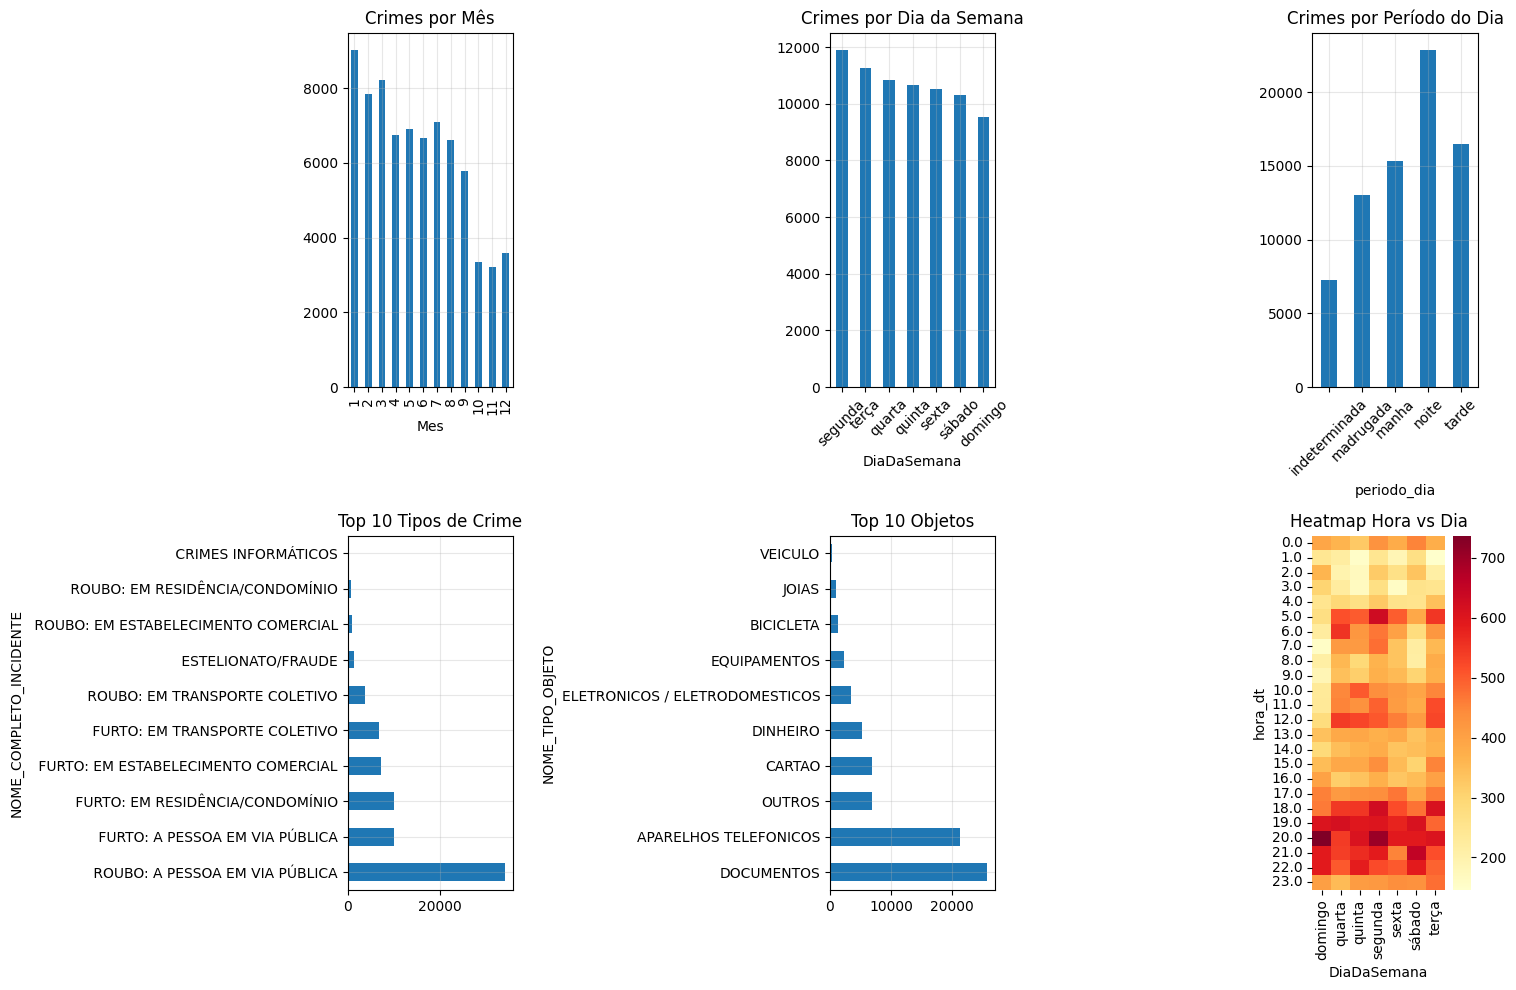


=== INSIGHTS PRINCIPAIS ===
Top 10 padrões para furto de aparelhos telefônicos:
  VIA PÚBLICA | noite | domingo: 3.4% (732 casos)
  VIA PÚBLICA | noite | segunda: 3.4% (729 casos)
  VIA PÚBLICA | noite | sábado: 3.4% (722 casos)
  VIA PÚBLICA | noite | terça: 3.4% (721 casos)
  VIA PÚBLICA | noite | quinta: 3.1% (669 casos)
  VIA PÚBLICA | noite | sexta: 3.0% (646 casos)
  VIA PÚBLICA | noite | quarta: 2.9% (630 casos)
  VIA PÚBLICA | madrugada | segunda: 2.1% (447 casos)
  VIA PÚBLICA | tarde | domingo: 2.1% (444 casos)
  VIA PÚBLICA | tarde | terça: 2.0% (419 casos)


In [72]:
sistema.analise_exploratoria(tipo='temporal_basica')

18:38:00 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
18:38:00 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



=== ANÁLISE TEMPORAL AVANÇADA ===


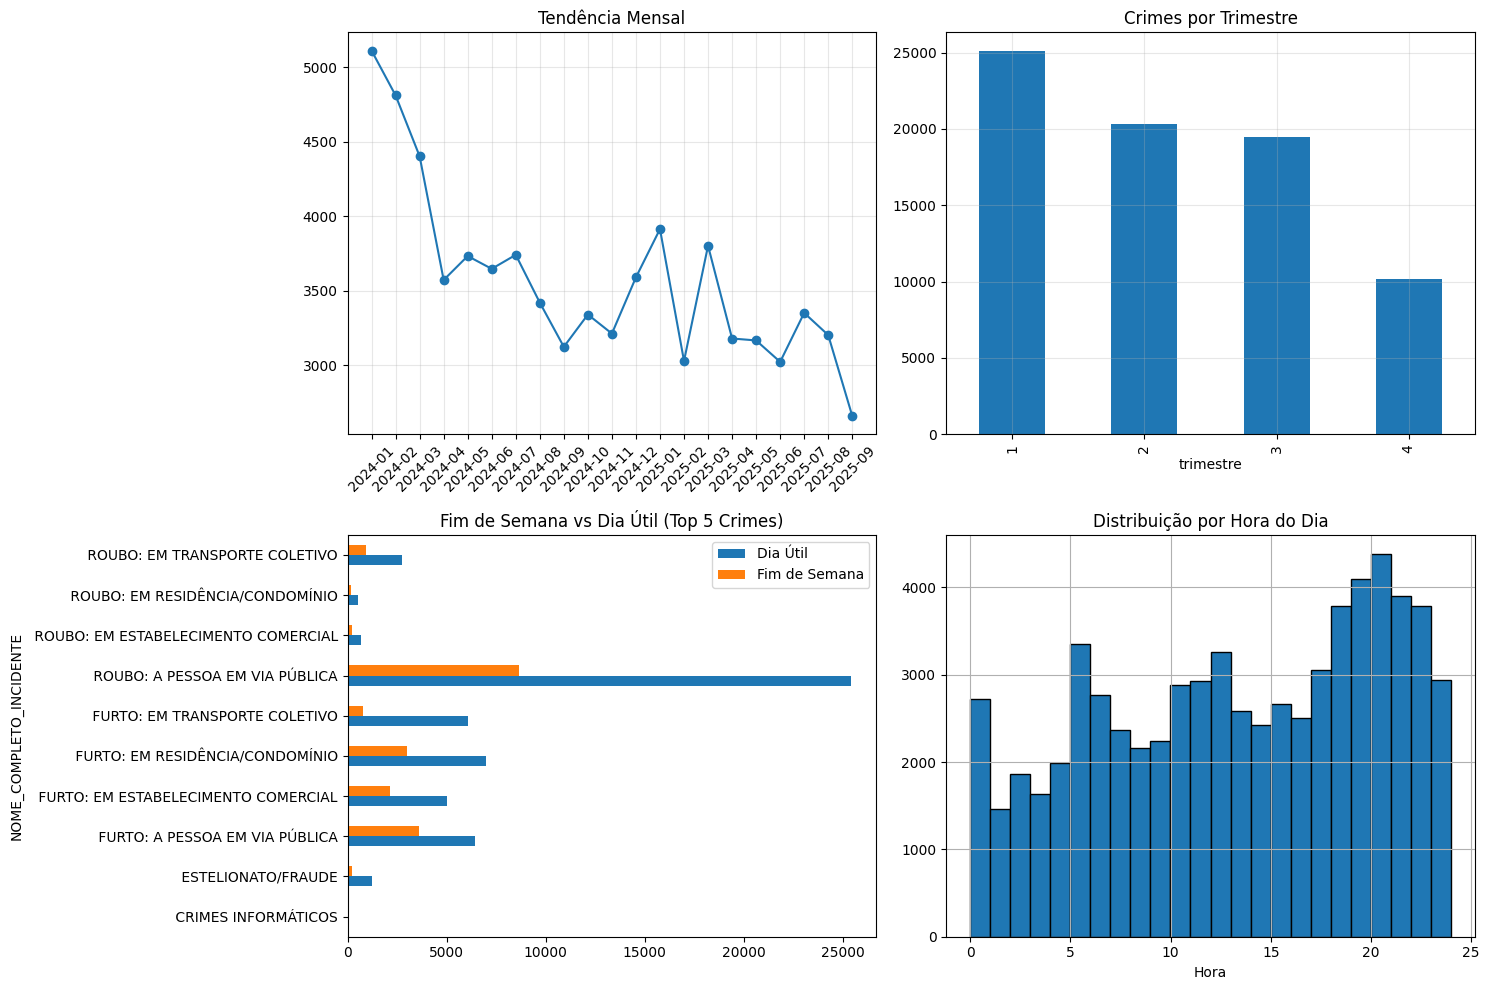

In [73]:
# 3. Executar análises
sistema.analise_exploratoria(tipo='temporal_avancada')


=== ANÁLISE ESPACIAL ===


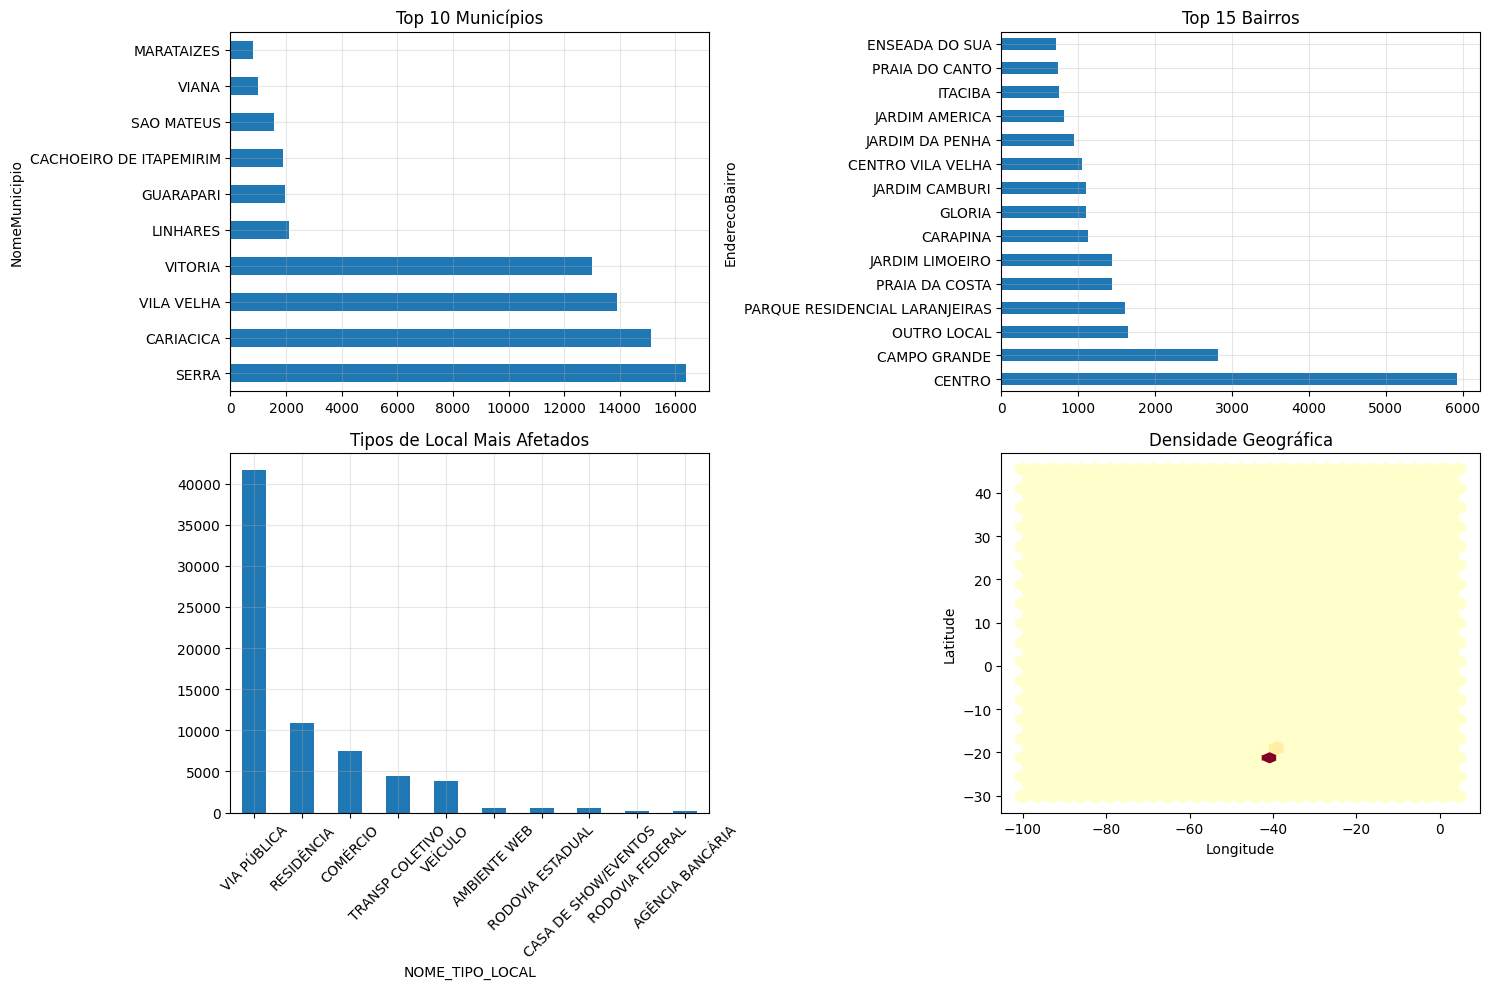


Hotspots por município:
  SERRA: 16393 crimes - Mais comum:  ROUBO: A PESSOA EM VIA PÚBLICA
  CARIACICA: 15118 crimes - Mais comum:  ROUBO: A PESSOA EM VIA PÚBLICA
  VILA VELHA: 13909 crimes - Mais comum:  ROUBO: A PESSOA EM VIA PÚBLICA
  VITORIA: 12995 crimes - Mais comum:  ROUBO: A PESSOA EM VIA PÚBLICA
  LINHARES: 2123 crimes - Mais comum:  ROUBO: A PESSOA EM VIA PÚBLICA


In [74]:
# 3. Executar análises
sistema.analise_exploratoria(tipo='espacial')


=== ANÁLISE POR TIPO DE CRIME ===


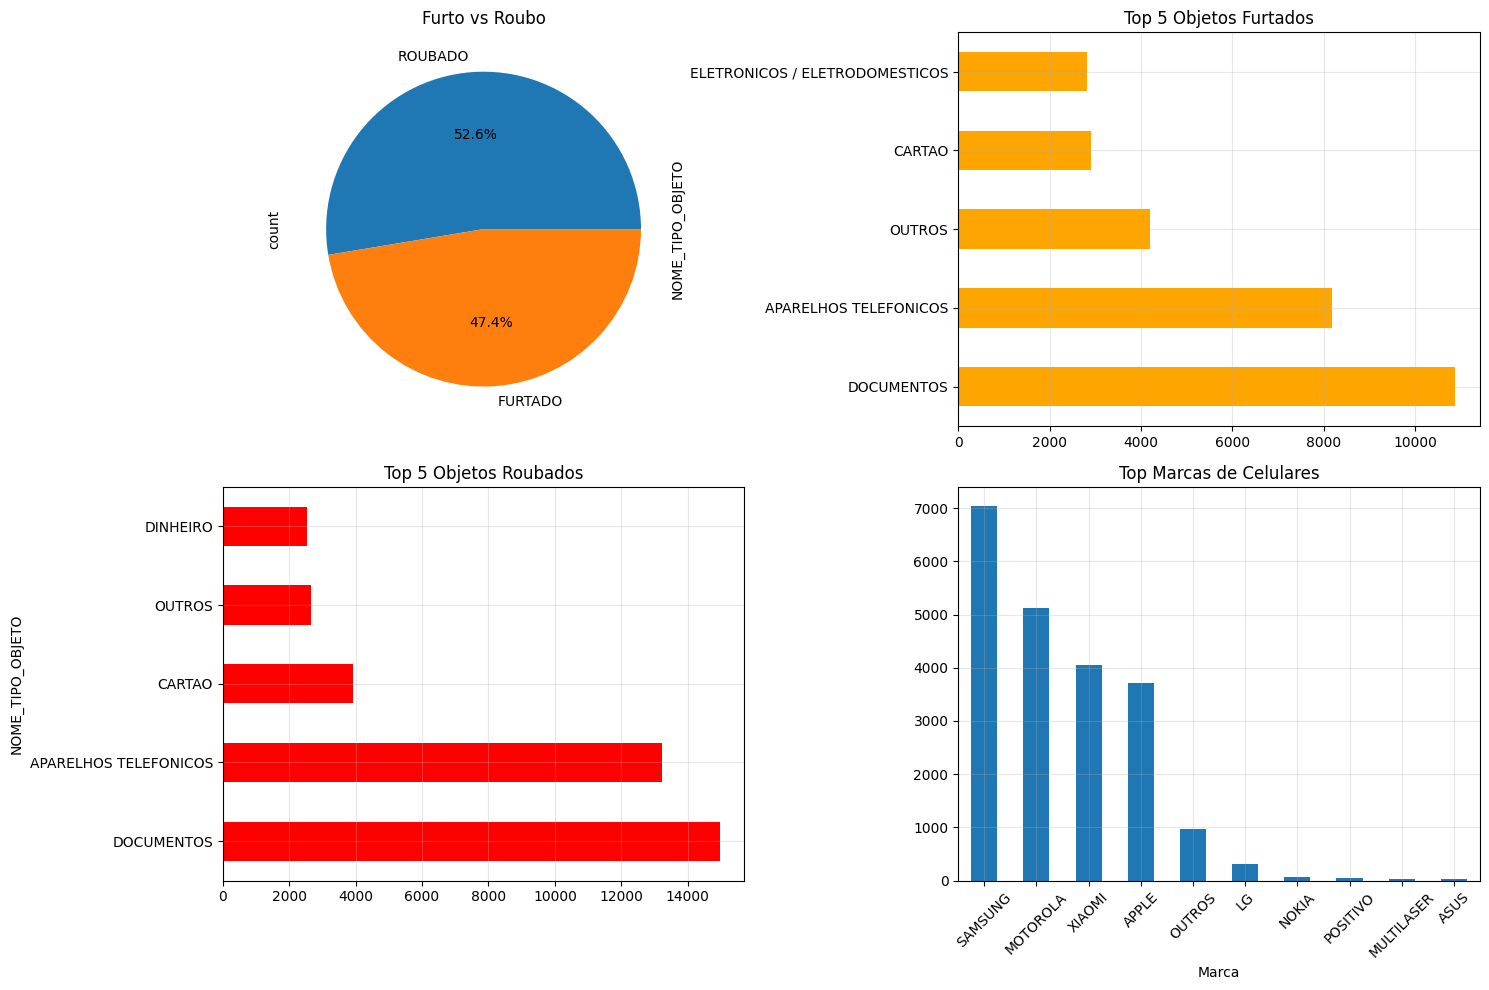

In [75]:
# 3. Executar análises
sistema.analise_exploratoria(tipo='crimes')


=== ANÁLISE DE CORRELAÇÕES ===


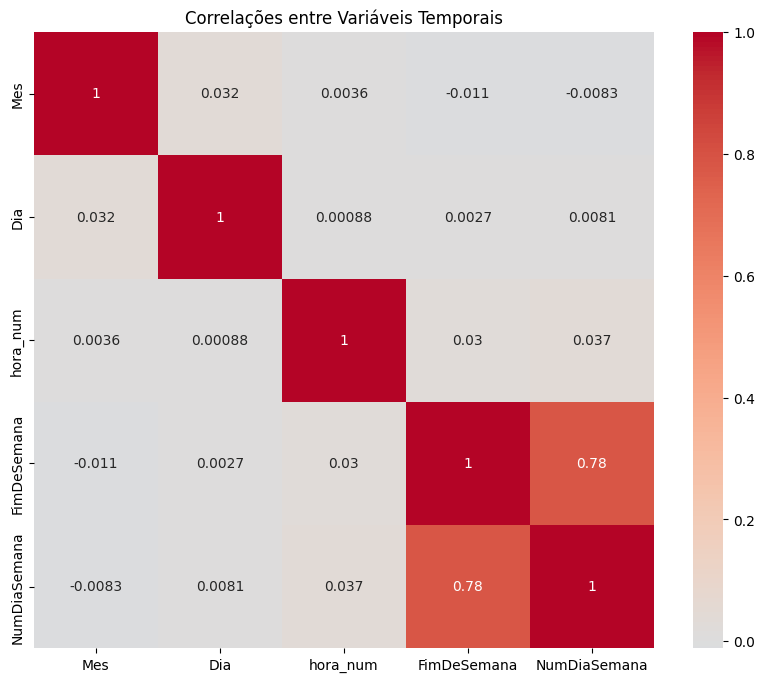

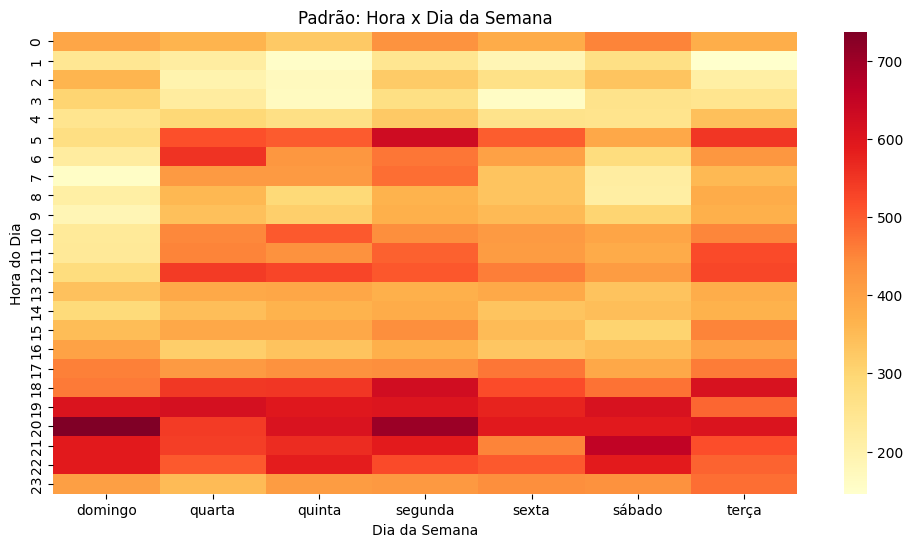

In [76]:
# 3. Executar análises
sistema.analise_exploratoria(tipo='correlacoes')

In [77]:
# 4. (Opcional) Otimizar hiperparâmetros - apenas primeira vez
params = sistema.otimizar_hiperparametros()

18:38:02 | INFO     | ======================================================================
18:38:02 | INFO     |                 OTIMIZAÇÃO COMPLETA DE HIPERPARÂMETROS                
18:38:02 | INFO     | ======================================================================
18:38:02 | WARNING  | Isso pode demorar um pouco dependendo do tamanho do dataset
18:38:02 | INFO     | Execute APENAS na primeira vez ou a cada 3-6 meses
18:38:02 | INFO     | 
18:38:02 | INFO     | Usando 12 meses (2024-01-01 a 2024-12-31)
18:38:02 | INFO     | 
18:38:02 | INFO     | REGRESSÃO - problema de previsão de Volume
18:38:02 | INFO     | Agregando dados...
18:38:02 | INFO     | ======================================================================
18:38:02 | INFO     |                        OTIMIZANDO RF_REGRESSOR                        
18:38:02 | INFO     | ======================================================================
18:38:02 | INFO     | ✓ Validação OK: 3 folds para 12 meses
18:38:02 | 

In [78]:
# 5.1 Treinar volume
sistema.volume_predictor.treinar_kfold(
    data_final_treino='2024-12-31',
    meses_janela=12,
    n_folds=3,
    otimizar=False,  # otimizar=False porque já otimizou acima
    validar=True
)

18:55:54 | INFO     | ======================================================================
18:55:54 | INFO     |                    TREINO VOLUME - K-FOLD TEMPORAL                    
18:55:54 | INFO     | ======================================================================
18:55:54 | INFO     | Janela: 2024-01-01 a 2024-12-31
18:55:54 | INFO     | Total de meses: 12 (2024-01 a 2024-12)
18:55:54 | INFO     | ✓ Validação OK: 3 folds para 12 meses
18:55:54 | INFO     | Configuração: 3 folds, janelas de 3 meses
18:55:54 | INFO     | ======================================================================
18:55:54 | INFO     | [PARÂMETROS OTIMIZADOS]: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}
18:55:54 | INFO     | 
18:55:54 | INFO     | [FASE 2: VALIDAÇÃO K-FOLD]
18:55:54 | INFO     | 
Fold 1/3:
18:55:54 | INFO     |   Treino: 2024-01-01 a 2024-03-31 (3 meses, 5009 registros)
18:55:54 | INFO     |   Validação: 2024-04-01 a 2024-06-30 (3 meses, 

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
# 5.2 Treinar classificação
X, y = sistema.crime_classifier.preparar_features()
sistema.crime_classifier.treinar_kfold(X, y, otimizar=False, validar=True) # otimizar=False porque já otimizou acima

18:55:55 | INFO     | Preparando features...
18:55:55 | INFO     | ======================================================================
18:55:55 | INFO     |                 TREINO CLASSIFICAÇÃO - K-FOLD TEMPORAL                
18:55:55 | INFO     | ======================================================================
18:55:55 | INFO     | Janela de treino: 2024-01-01 a 2024-12-31 (12 meses)
18:55:55 | INFO     | Total de meses: 12 (2024-01 a 2024-12)
18:55:55 | INFO     | ✓ Validação OK: 3 folds para 12 meses
18:55:55 | INFO     | Configuração: 3 folds, janelas de 3 meses
18:55:55 | INFO     | ======================================================================
18:55:55 | INFO     | 
18:55:55 | INFO     | [FASE 2: VALIDAÇÃO K-FOLD]
18:55:55 | INFO     | 
Fold 1/3:
18:55:55 | INFO     |   Treino: 2024-01-01 a 2024-03-31 (3 meses, 14328 registros)
18:55:55 | INFO     |   Validação: 2024-04-01 a 2024-06-30 (3 meses, 10952 registros)
18:56:02 | INFO     |   RF: F1=0.860, Acc=0.864 |

{'random_forest': RandomForestClassifier(class_weight='balanced', max_depth=20,
                        min_samples_split=10, n_estimators=200, n_jobs=-1,
                        random_state=42),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, ...)}

In [80]:
# 6.1 Fazer predições de volume
vol = sistema.volume_predictor.prever_volume(
    data_inicio='2025-01-01',
    data_fim='2025-01-31',
    local='VIA PUBLICA',
    bairro='CENTRO',
    municipio='VITORIA'
)

18:56:25 | INFO     | 
PREVISÃO: 2025-01-01 a 2025-01-31 - VIA PUBLICA, CENTRO, VITORIA
18:56:26 | INFO     | Total previsto: 105 crimes


In [81]:
# 6.2 Fazer predições de tipos de crime
crime = sistema.crime_classifier.prever_crime(
    data='2025-01-15',
    hora='20:00',
    local='VIA PUBLICA',
    bairro='CENTRO',
    municipio='VITORIA',
    top_n=5,
    modelo='random_forest'
)

18:56:26 | INFO     | PREDIÇÃO: 2025-01-15 às 20:00 - VIA PUBLICA, CENTRO, VITORIA
18:56:26 | INFO     | RANDOM_FOREST:
18:56:26 | INFO     |   1. 43.5% -  ESTELIONATO/FRAUDE
18:56:26 | INFO     |   2. 24.1% -  FURTO: EM ESTABELECIMENTO COMERCIAL
18:56:26 | INFO     |   3. 15.5% -  FURTO: A PESSOA EM VIA PÚBLICA
18:56:26 | INFO     |   4. 5.8% -  CRIMES INFORMÁTICOS
18:56:26 | INFO     |   5. 5.7% -  FURTO: EM RESIDÊNCIA/CONDOMÍNIO


In [82]:
# 7.1 Avaliar volume em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_jan2025.parquet')


18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     | Dados: 3914 registros
18:56:26 | INFO     | Período: 2025-01-01 a 2025-01-31
18:56:26 | INFO     | MÉTRICAS: MAE=0.56 | RMSE=1.45 | R²=0.685
18:56:26 | INFO     | Baseline definido: 0.562
18:56:26 | INFO     | MONITOR DE DRIFT: Histórico insuficiente
18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     |                            AGREGAÇÃO MENSAL                           
18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     | Mês                Real   Previsto       Erro     Erro %
18:56:26 | INFO     | --------------------------------------------------------------------

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-01-01,ALTO LAGE,CARIACICA,7,7.034592,-0.034592,0.034592
1,2025-01-01,ARACA,LINHARES,5,5.038567,-0.038567,0.038567
2,2025-01-01,ARACAS,VILA VELHA,4,3.981580,0.018420,0.018420
3,2025-01-01,BAIRRO DAS LARANJEIRAS,SERRA,1,1.000000,0.000000,0.000000
4,2025-01-01,BAIRRO DE FATIMA,SERRA,3,3.115935,-0.115935,0.115935
...,...,...,...,...,...,...,...
1411,2025-01-31,SAO FRANCISCO,CARIACICA,6,2.593136,3.406864,3.406864
1412,2025-01-31,SAO TORQUATO,VILA VELHA,2,6.107992,-4.107992,4.107992
1413,2025-01-31,TERRA VERMELHA,VILA VELHA,1,1.000000,0.000000,0.000000
1414,2025-01-31,VALE ENCANTADO,VILA VELHA,2,2.044023,-0.044023,0.044023


In [83]:
# 8.2 Avaliar crime em dados futuros
sistema.crime_classifier.avaliar_dados_futuros('dados_jan2025.parquet')

18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     | Dados: 3914 registros
18:56:26 | INFO     | Período: 2025-01-01 a 2025-01-31
18:56:26 | WARNING  | 158 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
18:56:26 | INFO     | ESTATÍSTICAS: Total=3914
18:56:26 | INFO     | Random Forest - Accuracy: 88.7% | F1: 0.893
18:56:26 | INFO     | XGBoost       - Accuracy: 90.8% | F1: 0.913
18:56:26 | INFO     | Baseline definido: 0.913
18:56:26 | INFO     | MONITOR DE DRIFT: Histórico insuficiente
18:56:26 | INFO     | ======================================================================
18:56:26 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
18:56:26 | INFO     | =========================================

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.18      0.60      0.28        50
      FURTO: A PESSOA EM VIA PÚBLICA       0.86      0.83      0.85       572
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.93      0.85      0.88       394
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.96      0.94      0.95       648
       FURTO: EM TRANSPORTE COLETIVO       0.85      0.77      0.81       281
      ROUBO: A PESSOA EM VIA PÚBLICA       0.94      0.97      0.95      1723
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.59      0.94      0.72        31
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.80      0.33      0.47        36
       ROUBO: EM TRANSPORTE COLETIVO       0.90      0.56      0.69       179

                            accuracy                           0.89      3914
                           macro avg       0.78      0.75      0.73      3914
                        weighted avg       0.91      0.89     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-01-29,11:31,CAMPO GRANDE,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
1,2025-01-29,11:31,CAMPO GRANDE,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
2,2025-01-29,11:31,CAMPO GRANDE,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3,2025-01-29,11:31,CAMPO GRANDE,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
4,2025-01-29,11:31,CAMPO GRANDE,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
...,...,...,...,...,...,...,...,...
3909,2025-01-02,10:59,NOVO PORTO CANOA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3910,2025-01-27,11:15,BAIRRO DAS LARANJEIRAS,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
3911,2025-01-03,22:50,EURICO SALLES,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,1,0
3912,2025-01-12,21:00,JARDIM TROPICAL,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,1,0


In [97]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_fev2025.parquet')

10:44:02 | INFO     | ======================================================================
10:44:02 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:44:02 | INFO     | ======================================================================
10:44:02 | INFO     | Dados: 3029 registros
10:44:02 | INFO     | Período: 2025-02-01 a 2025-02-28
10:44:02 | INFO     | MÉTRICAS: MAE=0.42 | RMSE=1.02 | R²=0.785
10:44:02 | INFO     | MONITOR DE DRIFT: DRIFT SEVERO! 25.3% vs baseline. REOTIMIZAR!
10:44:02 | INFO     | ======================================================================
10:44:02 | INFO     |                            AGREGAÇÃO MENSAL                           
10:44:02 | INFO     | ======================================================================
10:44:02 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:44:02 | INFO     | --------------------------------------------------------------------------------
10:44:02 | I

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-02-01,ALCEBIADES,MONTANHA,1,1.000000,0.000000,0.000000
1,2025-02-01,ALTO DA BOA VISTA,CARIACICA,1,1.000000,0.000000,0.000000
2,2025-02-01,ALTO NOVA ALMEIDA,MARECHAL FLORIANO,2,2.037626,-0.037626,0.037626
3,2025-02-01,ARIBIRI,VILA VELHA,1,1.000000,0.000000,0.000000
4,2025-02-01,BARRA DE ITAPEMIRIM,MARATAIZES,4,3.924689,0.075311,0.075311
...,...,...,...,...,...,...,...
1167,2025-02-28,SAO TORQUATO,VILA VELHA,3,2.552086,0.447914,0.447914
1168,2025-02-28,SOTECO,VILA VELHA,7,7.464306,-0.464306,0.464306
1169,2025-02-28,TUCUM,CARIACICA,1,1.239988,-0.239988,0.239988
1170,2025-02-28,VERA CRUZ,CARIACICA,1,1.000000,0.000000,0.000000


In [98]:
sistema.crime_classifier.avaliar_dados_futuros('dados_fev2025.parquet')

10:44:10 | INFO     | ======================================================================
10:44:10 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:44:10 | INFO     | ======================================================================
10:44:10 | INFO     | Dados: 3029 registros
10:44:10 | INFO     | Período: 2025-02-01 a 2025-02-28
10:44:10 | WARNING  | 179 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:44:11 | INFO     | ESTATÍSTICAS: Total=3029
10:44:11 | INFO     | Random Forest - Accuracy: 87.5% | F1: 0.884
10:44:11 | INFO     | XGBoost       - Accuracy: 89.6% | F1: 0.901
10:44:11 | INFO     | MONITOR DE DRIFT: Performance estável (+1.3%)
10:44:11 | INFO     | ======================================================================
10:44:11 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:44:11 | INFO     | ======================================================================
10:44:11 | I

                                      precision    recall  f1-score   support

                 CRIMES INFORMÁTICOS       0.00      0.00      0.00         1
                  ESTELIONATO/FRAUDE       0.22      0.63      0.33        75
      FURTO: A PESSOA EM VIA PÚBLICA       0.86      0.73      0.79       455
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.93      0.86      0.89       242
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.94      0.97      0.96       482
       FURTO: EM TRANSPORTE COLETIVO       0.80      0.77      0.78       270
      ROUBO: A PESSOA EM VIA PÚBLICA       0.96      0.96      0.96      1321
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.87      0.96      0.91        27
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.83      0.18      0.29        28
       ROUBO: EM TRANSPORTE COLETIVO       0.92      0.73      0.81       128

                            accuracy                           0.88      3029
                           macro avg       0.73      0.68     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-02-27,20:40,SANTA LUCIA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
1,2025-02-28,07:03,CENTRO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
2,2025-02-05,09:00,TERRA VERMELHA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3,2025-02-28,00:00,CENTRO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-02-22,08:15,MUQUICABA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
...,...,...,...,...,...,...,...,...
3024,2025-02-27,23:00,ALVORADA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,1,1
3025,2025-02-13,09:00,CRISTOVAO COLOMBO,FURTO: EM ESTABELECIMENTO COMERCIAL,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,0
3026,2025-02-28,22:40,BARRA DO JUCU,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1
3027,2025-02-15,16:00,PRAIA DA COSTA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1


In [99]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_mar2025.parquet')

10:44:19 | INFO     | ======================================================================
10:44:19 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:44:19 | INFO     | ======================================================================
10:44:19 | INFO     | Dados: 3804 registros
10:44:19 | INFO     | Período: 2025-03-01 a 2025-03-31
10:44:20 | INFO     | MÉTRICAS: MAE=0.72 | RMSE=5.61 | R²=0.426
10:44:20 | INFO     | MONITOR DE DRIFT: Performance estável (-28.8%)
10:44:20 | INFO     | ======================================================================
10:44:20 | INFO     |                            AGREGAÇÃO MENSAL                           
10:44:20 | INFO     | ======================================================================
10:44:20 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:44:20 | INFO     | --------------------------------------------------------------------------------
10:44:20 | INFO     | 2025-0

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-03-01,ARACAS,VILA VELHA,1,1.000000,0.000000,0.000000
1,2025-03-01,ARACAS,VILA VELHA,10,10.039111,-0.039111,0.039111
2,2025-03-01,BENTO FERREIRA,VITORIA,1,1.000000,0.000000,0.000000
3,2025-03-01,CAMPO GRANDE,CARIACICA,1,1.000000,0.000000,0.000000
4,2025-03-01,CENTRAL CARAPINA,SERRA,5,4.946203,0.053797,0.053797
...,...,...,...,...,...,...,...
1328,2025-03-31,SAO GERALDO,CARIACICA,2,2.284462,-0.284462,0.284462
1329,2025-03-31,SERRA DOURADA II,SERRA,1,1.000000,0.000000,0.000000
1330,2025-03-31,TABAJARA,CARIACICA,4,4.300577,-0.300577,0.300577
1331,2025-03-31,VERA CRUZ,CARIACICA,4,3.404248,0.595752,0.595752


In [100]:
sistema.crime_classifier.avaliar_dados_futuros('dados_mar2025.parquet')

10:44:32 | INFO     | ======================================================================
10:44:32 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:44:32 | INFO     | ======================================================================
10:44:33 | INFO     | Dados: 3804 registros
10:44:33 | INFO     | Período: 2025-03-01 a 2025-03-31
10:44:33 | WARNING  | 151 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:44:34 | INFO     | ESTATÍSTICAS: Total=3804
10:44:34 | INFO     | Random Forest - Accuracy: 89.2% | F1: 0.901
10:44:34 | INFO     | XGBoost       - Accuracy: 90.8% | F1: 0.912
10:44:34 | INFO     | MONITOR DE DRIFT: Performance estável (+0.1%)
10:44:34 | INFO     | ======================================================================
10:44:34 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:44:34 | INFO     | ======================================================================
10:44:34 | I

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.17      0.42      0.24        64
      FURTO: A PESSOA EM VIA PÚBLICA       0.92      0.85      0.88       833
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.88      0.86      0.87       293
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.98      0.93      0.95       504
       FURTO: EM TRANSPORTE COLETIVO       0.84      0.88      0.86       313
      ROUBO: A PESSOA EM VIA PÚBLICA       0.97      0.95      0.96      1591
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.54      0.94      0.69        36
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.79      0.52      0.63        44
       ROUBO: EM TRANSPORTE COLETIVO       0.70      0.71      0.71       126

                            accuracy                           0.89      3804
                           macro avg       0.75      0.79      0.75      3804
                        weighted avg       0.91      0.89     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-03-10,22:00,IBES,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
1,2025-03-07,16:37,CARAPINA I,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
2,2025-03-18,08:20,PARQUE RESIDENCIAL LARANJEIRAS,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3,2025-03-18,08:20,PARQUE RESIDENCIAL LARANJEIRAS,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
4,2025-03-18,08:20,PARQUE RESIDENCIAL LARANJEIRAS,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
...,...,...,...,...,...,...,...,...
3799,2025-03-02,13:44,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3800,2025-03-03,17:00,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3801,2025-03-15,03:00,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1
3802,2025-03-15,03:00,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1


In [101]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_abr2025.parquet')

10:44:41 | INFO     | ======================================================================
10:44:41 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:44:41 | INFO     | ======================================================================
10:44:41 | INFO     | Dados: 3180 registros
10:44:41 | INFO     | Período: 2025-04-01 a 2025-04-30
10:44:41 | INFO     | MÉTRICAS: MAE=0.47 | RMSE=1.16 | R²=0.756
10:44:41 | INFO     | MONITOR DE DRIFT: Drift detectado! 12.7% vs recente.
10:44:41 | INFO     | ======================================================================
10:44:41 | INFO     |                            AGREGAÇÃO MENSAL                           
10:44:41 | INFO     | ======================================================================
10:44:41 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:44:41 | INFO     | --------------------------------------------------------------------------------
10:44:41 | INFO     | 

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-04-01,ALA NOVA DE CAMPINHO,DOMINGOS MARTINS,2,1.980098,0.019902,0.019902
1,2025-04-01,ALTO LAGE,CARIACICA,1,1.000000,0.000000,0.000000
2,2025-04-01,ARACAS,VILA VELHA,1,1.000000,0.000000,0.000000
3,2025-04-01,ARIBIRI,VILA VELHA,5,5.126109,-0.126109,0.126109
4,2025-04-01,ATAIDE,VILA VELHA,5,5.096109,-0.096109,0.096109
...,...,...,...,...,...,...,...
1195,2025-04-30,PITANGA,SERRA,1,1.000000,0.000000,0.000000
1196,2025-04-30,PRAIA DA COSTA,VILA VELHA,3,1.219942,1.780058,1.780058
1197,2025-04-30,PRAIA DA COSTA,VILA VELHA,1,1.000000,0.000000,0.000000
1198,2025-04-30,SAO BENEDITO,CARIACICA,1,1.000000,0.000000,0.000000


In [102]:
sistema.crime_classifier.avaliar_dados_futuros('dados_abr2025.parquet')

10:45:03 | INFO     | ======================================================================
10:45:03 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:45:03 | INFO     | ======================================================================
10:45:03 | INFO     | Dados: 3180 registros
10:45:03 | INFO     | Período: 2025-04-01 a 2025-04-30
10:45:03 | WARNING  | 151 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:45:03 | INFO     | ESTATÍSTICAS: Total=3180
10:45:03 | INFO     | Random Forest - Accuracy: 88.6% | F1: 0.896
10:45:03 | INFO     | XGBoost       - Accuracy: 90.1% | F1: 0.907
10:45:03 | INFO     | MONITOR DE DRIFT: Performance estável (+0.7%)
10:45:03 | INFO     | ======================================================================
10:45:03 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:45:03 | INFO     | ======================================================================
10:45:03 | I

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.22      0.67      0.33        52
      FURTO: A PESSOA EM VIA PÚBLICA       0.85      0.78      0.82       429
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.85      0.83      0.84       295
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.97      0.91      0.94       400
       FURTO: EM TRANSPORTE COLETIVO       0.93      0.87      0.90       418
      ROUBO: A PESSOA EM VIA PÚBLICA       0.97      0.95      0.96      1393
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.51      0.75      0.61        32
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       1.00      0.32      0.48        22
       ROUBO: EM TRANSPORTE COLETIVO       0.77      0.88      0.82       139

                            accuracy                           0.89      3180
                           macro avg       0.79      0.77      0.74      3180
                        weighted avg       0.91      0.89     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-04-30,12:36,OUTRO LOCAL,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
1,2025-04-10,12:30,OUTRO LOCAL,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
2,2025-04-08,11:44,MONTE BELO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3,2025-04-23,18:41,BENTO FERREIRA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-04-02,17:50,PRAIA DO CANTO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
...,...,...,...,...,...,...,...,...
3175,2025-04-28,20:30,JARDIM CAMBURI,FURTO: EM ESTABELECIMENTO COMERCIAL,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3176,2025-04-16,17:12,CENTRO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
3177,2025-04-26,15:20,SANTA LUCIA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3178,2025-04-05,18:30,GRANDE VITORIA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1


In [103]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_mai2025.parquet')

10:45:27 | INFO     | ======================================================================
10:45:27 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:45:27 | INFO     | ======================================================================
10:45:27 | INFO     | Dados: 3181 registros
10:45:27 | INFO     | Período: 2025-05-01 a 2025-05-31
10:45:27 | INFO     | MÉTRICAS: MAE=0.62 | RMSE=3.89 | R²=0.204
10:45:27 | INFO     | MONITOR DE DRIFT: Performance estável (-10.5%)
10:45:27 | INFO     | ======================================================================
10:45:27 | INFO     |                            AGREGAÇÃO MENSAL                           
10:45:27 | INFO     | ======================================================================
10:45:27 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:45:27 | INFO     | --------------------------------------------------------------------------------
10:45:27 | INFO     | 2025-0

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-05-01,BAIRRO DE FATIMA,SERRA,2,1.988026,0.011974,0.011974
1,2025-05-01,BALNEARIO MEAIPE,GUARAPARI,1,1.000000,0.000000,0.000000
2,2025-05-01,BARCELONA,SERRA,1,1.000000,0.000000,0.000000
3,2025-05-01,BARRA DO JUCU,VILA VELHA,1,1.000000,0.000000,0.000000
4,2025-05-01,CARAPINA,SERRA,3,3.137767,-0.137767,0.137767
...,...,...,...,...,...,...,...
1234,2025-05-31,RIO MARINHO,VILA VELHA,4,2.974927,1.025073,1.025073
1235,2025-05-31,ROMAO,VITORIA,1,1.000000,0.000000,0.000000
1236,2025-05-31,SANTA CECILIA,CARIACICA,1,1.000000,0.000000,0.000000
1237,2025-05-31,SANTANA,CARIACICA,1,2.250169,-1.250169,1.250169


In [104]:
sistema.crime_classifier.avaliar_dados_futuros('dados_mai2025.parquet')

10:45:34 | INFO     | ======================================================================
10:45:34 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:45:34 | INFO     | ======================================================================
10:45:34 | INFO     | Dados: 3181 registros
10:45:34 | INFO     | Período: 2025-05-01 a 2025-05-31
10:45:34 | WARNING  | 149 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:45:34 | INFO     | ESTATÍSTICAS: Total=3181
10:45:34 | INFO     | Random Forest - Accuracy: 89.8% | F1: 0.906
10:45:34 | INFO     | XGBoost       - Accuracy: 91.2% | F1: 0.917
10:45:34 | INFO     | MONITOR DE DRIFT: Performance estável (-0.4%)
10:45:34 | INFO     | ======================================================================
10:45:34 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:45:34 | INFO     | ======================================================================
10:45:34 | I

                                      precision    recall  f1-score   support

                 CRIMES INFORMÁTICOS       0.00      0.00      0.00         3
                  ESTELIONATO/FRAUDE       0.22      0.80      0.35        50
      FURTO: A PESSOA EM VIA PÚBLICA       0.87      0.75      0.81       334
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.97      0.89      0.93       502
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.96      0.92      0.94       370
       FURTO: EM TRANSPORTE COLETIVO       0.85      0.88      0.86       282
      ROUBO: A PESSOA EM VIA PÚBLICA       0.97      0.96      0.96      1496
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.67      0.96      0.79        27
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.00      0.00      0.00        20
       ROUBO: EM TRANSPORTE COLETIVO       0.81      0.72      0.77        97

                            accuracy                           0.90      3181
                           macro avg       0.63      0.69     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-05-30,02:00,PRAIA DA COSTA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
1,2025-05-30,02:00,PRAIA DA COSTA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
2,2025-05-13,11:00,COQUEIRAL DE ITAPARICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3,2025-05-19,17:12,ZONA RURAL,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-05-16,15:00,CENTRO,CRIMES INFORMÁTICOS,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
...,...,...,...,...,...,...,...,...
3176,2025-05-04,15:00,PRAIA DA COSTA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3177,2025-05-25,07:00,ARIBIRI,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3178,2025-05-22,09:00,ALVORADA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3179,2025-05-28,09:20,RESIDENCIAL COQUEIRAL,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,1,1


In [105]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_jun2025.parquet')

10:45:40 | INFO     | ======================================================================
10:45:40 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:45:40 | INFO     | ======================================================================
10:45:40 | INFO     | Dados: 3033 registros
10:45:40 | INFO     | Período: 2025-06-01 a 2025-06-30
10:45:41 | INFO     | MÉTRICAS: MAE=0.49 | RMSE=1.19 | R²=0.740
10:45:41 | INFO     | MONITOR DE DRIFT: Performance estável (+12.5%)
10:45:41 | INFO     | ======================================================================
10:45:41 | INFO     |                            AGREGAÇÃO MENSAL                           
10:45:41 | INFO     | ======================================================================
10:45:41 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:45:41 | INFO     | --------------------------------------------------------------------------------
10:45:41 | INFO     | 2025-0

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-06-01,ALECRIM,VILA VELHA,1,1.000000,0.000000,0.000000
1,2025-06-01,BARRA NOVA,SAO MATEUS,1,1.000000,0.000000,0.000000
2,2025-06-01,BELA VISTA,VITORIA,1,1.000000,0.000000,0.000000
3,2025-06-01,BRACO DO RIO,CONCEICAO DA BARRA,1,1.000000,0.000000,0.000000
4,2025-06-01,CAMPO GRANDE,CARIACICA,5,5.090242,-0.090242,0.090242
...,...,...,...,...,...,...,...
1182,2025-06-30,SAO GERALDO,SERRA,2,2.093819,-0.093819,0.093819
1183,2025-06-30,SAO MARCOS II,SERRA,1,1.000000,0.000000,0.000000
1184,2025-06-30,SAO TORQUATO,VILA VELHA,2,1.999451,0.000549,0.000549
1185,2025-06-30,VALE ENCANTADO,VILA VELHA,3,2.473458,0.526542,0.526542


In [106]:
sistema.crime_classifier.avaliar_dados_futuros('dados_jun2025.parquet')

10:45:45 | INFO     | ======================================================================
10:45:45 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:45:45 | INFO     | ======================================================================
10:45:45 | INFO     | Dados: 3033 registros
10:45:45 | INFO     | Período: 2025-06-01 a 2025-06-30
10:45:45 | WARNING  | 127 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:45:45 | INFO     | ESTATÍSTICAS: Total=3033
10:45:45 | INFO     | Random Forest - Accuracy: 88.3% | F1: 0.894
10:45:45 | INFO     | XGBoost       - Accuracy: 90.0% | F1: 0.908
10:45:45 | INFO     | MONITOR DE DRIFT: Performance estável (+0.5%)
10:45:45 | INFO     | ======================================================================
10:45:45 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:45:45 | INFO     | ======================================================================
10:45:45 | I

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.17      0.48      0.25        46
      FURTO: A PESSOA EM VIA PÚBLICA       0.86      0.81      0.84       427
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.92      0.80      0.86       247
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.90      0.92      0.91       391
       FURTO: EM TRANSPORTE COLETIVO       0.93      0.86      0.89       271
      ROUBO: A PESSOA EM VIA PÚBLICA       0.96      0.95      0.96      1525
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.23      0.64      0.34        22
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.88      0.48      0.62        46
       ROUBO: EM TRANSPORTE COLETIVO       0.74      0.69      0.71        58

                            accuracy                           0.88      3033
                           macro avg       0.73      0.74      0.71      3033
                        weighted avg       0.91      0.88     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-06-26,11:15,CAMPO GRANDE,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
1,2025-06-26,11:15,CAMPO GRANDE,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
2,2025-06-30,NaN,PONTAL DE CAMBURI,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3,2025-06-10,18:00,PRAIA DE ITAPARICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-06-23,00:00,CRISTOVAO COLOMBO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
...,...,...,...,...,...,...,...,...
3028,2025-06-23,07:00,CENTRO VILA VELHA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3029,2025-06-23,07:00,CENTRO VILA VELHA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3030,2025-06-23,07:00,CENTRO VILA VELHA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3031,2025-06-23,07:00,CENTRO VILA VELHA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0


In [107]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_jul2025.parquet')

10:45:53 | INFO     | ======================================================================
10:45:53 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:45:53 | INFO     | ======================================================================
10:45:53 | INFO     | Dados: 3359 registros
10:45:53 | INFO     | Período: 2025-07-01 a 2025-07-31
10:45:53 | INFO     | MÉTRICAS: MAE=0.44 | RMSE=1.01 | R²=0.743
10:45:53 | INFO     | MONITOR DE DRIFT: DRIFT SEVERO! 21.6% vs baseline. REOTIMIZAR!
10:45:53 | INFO     | ======================================================================
10:45:53 | INFO     |                            AGREGAÇÃO MENSAL                           
10:45:53 | INFO     | ======================================================================
10:45:53 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:45:53 | INFO     | --------------------------------------------------------------------------------
10:45:53 | I

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-07-01,ARLINDO ANGELO VILLASCHI,VIANA,1,1.000000,0.000000,0.000000
1,2025-07-01,BAIRRO DE FATIMA,SERRA,1,1.000000,0.000000,0.000000
2,2025-07-01,BAIRRO DE FATIMA,SERRA,4,4.350802,-0.350802,0.350802
3,2025-07-01,BELA AURORA,CARIACICA,3,3.167020,-0.167020,0.167020
4,2025-07-01,BOA VISTA DO SUL,MARATAIZES,1,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
1398,2025-07-31,VALPARAISO,SERRA,3,3.049627,-0.049627,0.049627
1399,2025-07-31,VILA NOVA,ARACRUZ,1,1.000000,0.000000,0.000000
1400,2025-07-31,VILA RICA,CACHOEIRO DE ITAPEMIRIM,1,1.000000,0.000000,0.000000
1401,2025-07-31,ZONA RURAL,RIO NOVO DO SUL,1,1.000000,0.000000,0.000000


In [108]:
sistema.crime_classifier.avaliar_dados_futuros('dados_jul2025.parquet')

10:46:03 | INFO     | ======================================================================
10:46:03 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:46:03 | INFO     | ======================================================================
10:46:03 | INFO     | Dados: 3359 registros
10:46:03 | INFO     | Período: 2025-07-01 a 2025-07-31
10:46:03 | WARNING  | 150 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:46:03 | INFO     | ESTATÍSTICAS: Total=3359
10:46:03 | INFO     | Random Forest - Accuracy: 87.5% | F1: 0.884
10:46:03 | INFO     | XGBoost       - Accuracy: 89.0% | F1: 0.894
10:46:03 | INFO     | MONITOR DE DRIFT: Performance estável (+2.0%)
10:46:03 | INFO     | ======================================================================
10:46:03 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:46:03 | INFO     | ======================================================================
10:46:03 | I

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.20      0.75      0.32        44
      FURTO: A PESSOA EM VIA PÚBLICA       0.81      0.69      0.75       484
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.89      0.92      0.90       364
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.95      0.90      0.92       462
       FURTO: EM TRANSPORTE COLETIVO       0.88      0.82      0.85       474
      ROUBO: A PESSOA EM VIA PÚBLICA       0.96      0.96      0.96      1372
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.75      0.94      0.83        32
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.71      0.42      0.53        24
       ROUBO: EM TRANSPORTE COLETIVO       0.78      0.76      0.77       103

                            accuracy                           0.88      3359
                           macro avg       0.77      0.80      0.76      3359
                        weighted avg       0.90      0.88     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-07-20,15:30,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,FURTO: EM ESTABELECIMENTO COMERCIAL,ESTELIONATO/FRAUDE,0,0
1,2025-07-20,15:30,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
2,2025-07-20,15:30,CENTRO,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3,2025-07-21,NaN,AEROPORTO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-07-21,NaN,AEROPORTO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
...,...,...,...,...,...,...,...,...
3354,2025-07-28,07:45,PARQUE MOSCOSO,FURTO: EM TRANSPORTE COLETIVO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3355,2025-07-28,07:45,PARQUE MOSCOSO,FURTO: EM TRANSPORTE COLETIVO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
3356,2025-07-23,21:06,NOVA PALESTINA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: EM ESTABELECIMENTO COMERCIAL,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
3357,2025-07-05,23:00,CENTRO,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,1,1


In [109]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_ago2025.parquet')

10:46:07 | INFO     | ======================================================================
10:46:07 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:46:07 | INFO     | ======================================================================
10:46:07 | INFO     | Dados: 3216 registros
10:46:07 | INFO     | Período: 2025-08-01 a 2025-08-31
10:46:07 | INFO     | MÉTRICAS: MAE=0.51 | RMSE=1.17 | R²=0.762
10:46:07 | INFO     | MONITOR DE DRIFT: Performance estável (+9.9%)
10:46:07 | INFO     | ======================================================================
10:46:07 | INFO     |                            AGREGAÇÃO MENSAL                           
10:46:07 | INFO     | ======================================================================
10:46:07 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:46:07 | INFO     | --------------------------------------------------------------------------------
10:46:07 | INFO     | 2025-08

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-08-01,AEROPORTO,VITORIA,3,3.150445,-0.150445,0.150445
1,2025-08-01,ALVORADA,VILA VELHA,3,3.194576,-0.194576,0.194576
2,2025-08-01,BAIRRO DE FATIMA,SERRA,1,1.000000,0.000000,0.000000
3,2025-08-01,BELA AURORA,CARIACICA,1,1.000000,0.000000,0.000000
4,2025-08-01,BENTO FERREIRA,VITORIA,1,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
1206,2025-08-31,RESIDENCIAL JACARAIPE,SERRA,2,2.224053,-0.224053,0.224053
1207,2025-08-31,RIO BRANCO,CARIACICA,2,2.661613,-0.661613,0.661613
1208,2025-08-31,TAQUARA II,SERRA,8,8.118595,-0.118595,0.118595
1209,2025-08-31,URTIGA,CACHOEIRO DE ITAPEMIRIM,1,1.000000,0.000000,0.000000


In [110]:
sistema.crime_classifier.avaliar_dados_futuros('dados_ago2025.parquet')

10:46:10 | INFO     | ======================================================================
10:46:10 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:46:10 | INFO     | ======================================================================
10:46:10 | INFO     | Dados: 3216 registros
10:46:10 | INFO     | Período: 2025-08-01 a 2025-08-31
10:46:10 | WARNING  | 206 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:46:10 | INFO     | ESTATÍSTICAS: Total=3216
10:46:10 | INFO     | Random Forest - Accuracy: 84.8% | F1: 0.860
10:46:10 | INFO     | XGBoost       - Accuracy: 86.0% | F1: 0.868
10:46:10 | INFO     | MONITOR DE DRIFT: Performance estável (+4.9%)
10:46:10 | INFO     | ======================================================================
10:46:10 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:46:10 | INFO     | ======================================================================
10:46:10 | I

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.22      0.70      0.33        73
      FURTO: A PESSOA EM VIA PÚBLICA       0.88      0.65      0.75       616
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.70      0.83      0.76       301
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.94      0.94      0.94       437
       FURTO: EM TRANSPORTE COLETIVO       0.91      0.83      0.87       471
      ROUBO: A PESSOA EM VIA PÚBLICA       0.96      0.95      0.95      1196
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.55      0.93      0.69        30
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       0.25      0.33      0.29         6
       ROUBO: EM TRANSPORTE COLETIVO       0.87      0.70      0.77        86

                            accuracy                           0.85      3216
                           macro avg       0.70      0.76      0.71      3216
                        weighted avg       0.89      0.85     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-08-19,20:00,RIBEIRAO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
1,2025-08-19,20:00,RIBEIRAO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
2,2025-08-19,20:00,RIBEIRAO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
3,2025-08-19,20:00,RIBEIRAO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
4,2025-08-19,20:00,RIBEIRAO,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
...,...,...,...,...,...,...,...,...
3211,2025-08-14,17:20,ARIBIRI,FURTO: EM TRANSPORTE COLETIVO,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,0
3212,2025-08-16,20:50,CENTRO VILA VELHA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: EM ESTABELECIMENTO COMERCIAL,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
3213,2025-08-15,22:00,CENTRO VILA VELHA,FURTO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,1
3214,2025-08-10,02:27,ITAPOA,FURTO: EM RESIDÊNCIA/CONDOMÍNIO,ESTELIONATO/FRAUDE,FURTO: A PESSOA EM VIA PÚBLICA,0,0


In [111]:
# 7. Avaliar em dados futuros
sistema.volume_predictor.avaliar_dados_futuros('dados_set2025.parquet')

10:46:16 | INFO     | ======================================================================
10:46:16 | INFO     |                    AVALIAÇÃO VOLUME - DADOS FUTUROS                   
10:46:16 | INFO     | ======================================================================
10:46:16 | INFO     | Dados: 2756 registros
10:46:16 | INFO     | Período: 2025-09-01 a 2025-09-30
10:46:16 | INFO     | MÉTRICAS: MAE=0.42 | RMSE=0.94 | R²=0.797
10:46:16 | INFO     | MONITOR DE DRIFT: DRIFT SEVERO! 24.6% vs baseline. REOTIMIZAR!
10:46:16 | INFO     | ======================================================================
10:46:16 | INFO     |                            AGREGAÇÃO MENSAL                           
10:46:16 | INFO     | ======================================================================
10:46:16 | INFO     | Mês                Real   Previsto       Erro     Erro %
10:46:16 | INFO     | --------------------------------------------------------------------------------
10:46:16 | I

,Data,Bairro,Municipio,Volume_Real,Volume_Previsto,Erro,Erro_Abs
0,2025-09-01,ALTO LAGE,CARIACICA,1,1.000000,0.000000,0.000000
1,2025-09-01,ALTOS SEBASTIAO,SANTA MARIA DE JETIBA,1,1.000000,0.000000,0.000000
2,2025-09-01,ATAIDE,VILA VELHA,1,1.000000,0.000000,0.000000
3,2025-09-01,BENTO FERREIRA,VITORIA,1,1.000000,0.000000,0.000000
4,2025-09-01,CAMPO GRANDE,CARIACICA,8,8.049357,-0.049357,0.049357
...,...,...,...,...,...,...,...
1167,2025-09-30,SANTA MARTHA,VITORIA,3,3.108399,-0.108399,0.108399
1168,2025-09-30,SAO FRANCISCO,SERRA,1,1.000000,0.000000,0.000000
1169,2025-09-30,VILA NOVA,VILA VELHA,3,3.065526,-0.065526,0.065526
1170,2025-09-30,VILA RUBIM,VITORIA,2,5.218742,-3.218742,3.218742


In [112]:
sistema.crime_classifier.avaliar_dados_futuros('dados_set2025.parquet')

10:46:20 | INFO     | ======================================================================
10:46:20 | INFO     |                AVALIAÇÃO CLASSIFICAÇÃO - DADOS FUTUROS                
10:46:20 | INFO     | ======================================================================
10:46:20 | INFO     | Dados: 2756 registros
10:46:20 | INFO     | Período: 2025-09-01 a 2025-09-30
10:46:20 | WARNING  | 89 valores desconhecidos em NOME_TIPO_LOCAL, usando fallback
10:46:20 | INFO     | ESTATÍSTICAS: Total=2756
10:46:20 | INFO     | Random Forest - Accuracy: 89.1% | F1: 0.895
10:46:20 | INFO     | XGBoost       - Accuracy: 90.7% | F1: 0.909
10:46:20 | INFO     | MONITOR DE DRIFT: Performance estável (+0.4%)
10:46:20 | INFO     | ======================================================================
10:46:20 | INFO     |                       RANDOM FOREST - VALIDAÇÃO                       
10:46:20 | INFO     | ======================================================================
10:46:20 | IN

                                      precision    recall  f1-score   support

                  ESTELIONATO/FRAUDE       0.25      0.56      0.35        48
      FURTO: A PESSOA EM VIA PÚBLICA       0.84      0.78      0.81       372
 FURTO: EM ESTABELECIMENTO COMERCIAL       0.87      0.88      0.88       314
     FURTO: EM RESIDÊNCIA/CONDOMÍNIO       0.93      0.93      0.93       367
       FURTO: EM TRANSPORTE COLETIVO       0.92      0.88      0.90       363
      ROUBO: A PESSOA EM VIA PÚBLICA       0.96      0.95      0.96      1193
 ROUBO: EM ESTABELECIMENTO COMERCIAL       0.76      0.88      0.82        33
     ROUBO: EM RESIDÊNCIA/CONDOMÍNIO       1.00      0.28      0.44        25
       ROUBO: EM TRANSPORTE COLETIVO       0.60      0.59      0.59        41

                            accuracy                           0.89      2756
                           macro avg       0.79      0.75      0.74      2756
                        weighted avg       0.90      0.89     

,Data,Hora,Bairro,Crime_Real,Pred_RF,Pred_XGB,Acerto_RF,Acerto_XGB
0,2025-09-11,09:00,CENTRO VILA VELHA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
1,2025-09-08,16:57,CENTRO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
2,2025-09-16,13:17,JUCUTUQUARA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
3,2025-09-03,NaN,CENTRO,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
4,2025-09-16,13:30,JARDIM DA PENHA,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,1,1
...,...,...,...,...,...,...,...,...
2751,2025-09-11,19:00,SOTECO,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,1,1
2752,2025-09-23,09:00,SANTA RITA,ROUBO: A PESSOA EM VIA PÚBLICA,ESTELIONATO/FRAUDE,ROUBO: A PESSOA EM VIA PÚBLICA,0,1
2753,2025-09-11,19:00,SOTECO,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,ROUBO: A PESSOA EM VIA PÚBLICA,1,1
2754,2025-09-09,18:10,COQUEIRAL DE ITAPARICA,FURTO: EM ESTABELECIMENTO COMERCIAL,ESTELIONATO/FRAUDE,ESTELIONATO/FRAUDE,0,0
